<a href="https://colab.research.google.com/github/paularedondosastre/APRENDIZAJE_AUTOMATICO_23_24/blob/main/Lab03_Definitivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 03 Ordinaria

Grupo A04

Lucía Casas, Marta Herraiz, Alba López, Paula Redondo

In [ ]:
pip install stemgraphic

In [ ]:
# Librerías necesarias
from google.colab import files

import pandas as pd
import numpy as np
import re
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import stemgraphic
import seaborn as sns

from google.colab import drive
import zipfile
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, chi2
from google.colab.patches import cv2_imshow
import cv2

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, recall_score

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from tabulate import tabulate

import warnings

# Desactivar todos los warnings
warnings.filterwarnings('ignore')

In [ ]:
# Carga de los archivos al directorio de trabajo
uploaded = files.upload()

## EJERCICIO 1:

 Vamos a realizar un clasificador usando la base de datos cancer.csv. La idea es que funcione como un Decision Support System, esto consiste en un sistema informático que ayuda a la toma de decisiones. Se creará un modelo basado en el clasificador que más se adapte a los datos, para ello se usará scikit-learn.

In [ ]:
data = pd.read_csv('cancer.csv')
print(data.head())

total_rows = data.shape[0]

print("Número total de filas:", total_rows)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

### Limpieza de la base de datos (apartado 1)

Primero vamos a ver cuántos valores Na hay en la base de datos y haremos algunos cambios de categóricas a numéricas para calcular la correlación más fácil

In [ ]:
nan_counts = data.isna().sum()
print(nan_counts)


id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Comprobamos que la variable Unnamed es la única que cuenta con datos NA, además tiene todas las filas sin valor. Por ello, vamos a eliminarla

In [ ]:
data.drop(columns=['Unnamed: 32'], inplace=True)

Para continuar, vamos a ver cuánta correlación existe entre las variables, para ello vamos a representar los datos con una matriz de correlación en un mapa de calor. Habrá varias variables correladas que generen ruido, dado que son datos sobre una misma caracaterística. Hay que tener en cuenta, que si tenemos una variable que indica el área, no necesitamos otra que dé el radio, estas dos variables estarán muy correladas y generarán ruido. Por ello, vamos a detectarlas y a eliminar las más correladas.

En primer lugar, vamos a visualizarlas en un mapa de calor, donde los colores más intensos se interpretan como una mayor correlación.

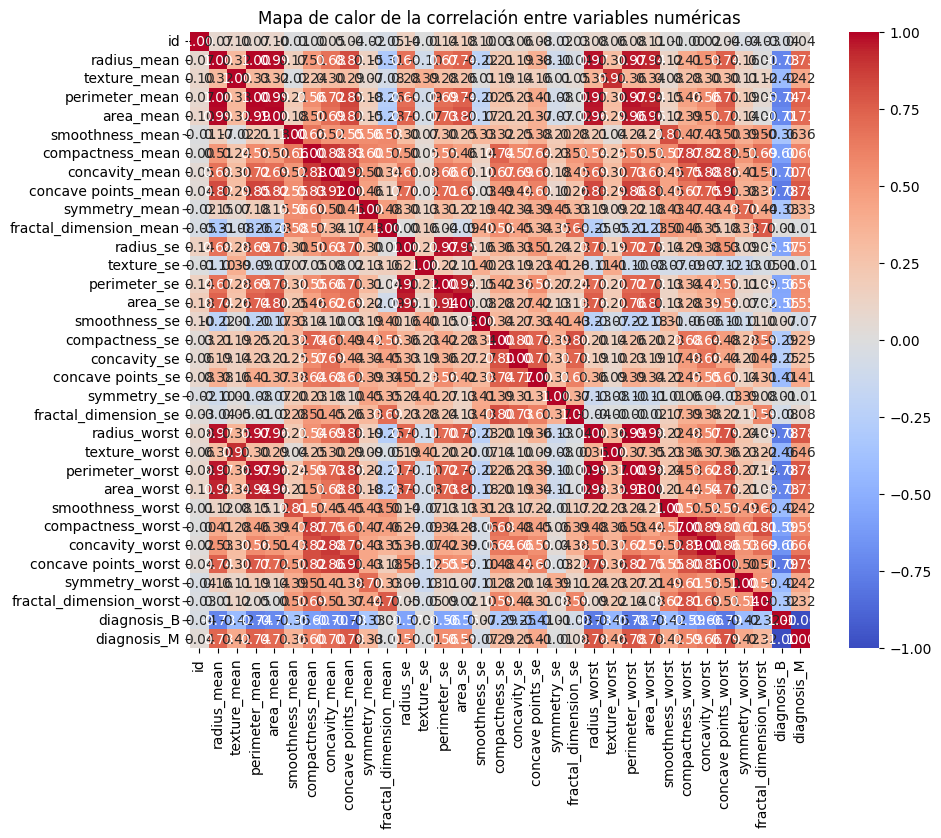

In [ ]:
# Codificación One-Hot para variables categóricas
data_encoded = pd.get_dummies(data)

correlation_matrix = data_encoded.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Mapa de calor de la correlación entre variables numéricas')
plt.show()


Dado que el mapa de calor se ve muy mal y no quedan claras las correlaciones vamos a usar un umbral para detectar las más correladas (las que superen dicho umbral). Para ello, usaremos que si el coeficiente de correlación es de 0.9 o -0.9, entonces estarán correladas, cuanto más cercano a 1 más correlación directa, cuanto más cercano a -1 más correlación inversa.

El resultado esperado será que las que se ven claras en el mapa de calor aparezcan como variables que han superado el umbral de correlación. Entre ellas, radius_worst con radius_mean, perimeter_mean y con area_mean; perimeter_worst con radius_mean, perimeter_mean y con area_mean; area_worst con radius_mean, perimeter_mean y con area_mean. Ya que estas variables tienen el rojo más intenso en el mapa de calor. Además, son características que explican cosas parecidas, a partir de una se podrían deducir las demás.

In [ ]:
strong_correlation_count = 0

# Umbral de correlación
threshold = 0.9

# Lista para almacenar las características con correlación fuerte
strong_correlation_features = []

# Iterar sobre la matriz de correlación
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) >= threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            strong_correlation_features.append((feature1, feature2, correlation))

# Imprimir las características con correlación fuerte
print("Características con correlación menor a -0.9 o mayor a 0.9:")
for feature_pair in strong_correlation_features:
    print(f"{feature_pair[0]} y {feature_pair[1]} tienen una correlación de {feature_pair[2]}")

Características con correlación menor a -0.9 o mayor a 0.9:
radius_mean y perimeter_mean tienen una correlación de 0.9978552814938109
radius_mean y area_mean tienen una correlación de 0.9873571700566127
radius_mean y radius_worst tienen una correlación de 0.9695389726112055
radius_mean y perimeter_worst tienen una correlación de 0.9651365139559871
radius_mean y area_worst tienen una correlación de 0.9410824595860461
texture_mean y texture_worst tienen una correlación de 0.912044588840421
perimeter_mean y area_mean tienen una correlación de 0.9865068039913907
perimeter_mean y radius_worst tienen una correlación de 0.9694763634663146
perimeter_mean y perimeter_worst tienen una correlación de 0.9703868870426394
perimeter_mean y area_worst tienen una correlación de 0.9415498080023068
area_mean y radius_worst tienen una correlación de 0.9627460860470841
area_mean y perimeter_worst tienen una correlación de 0.9591195743552645
area_mean y area_worst tienen una correlación de 0.959213325649899

Efectivamente, están correladas las variables mencionadas y algunas más. Dado que radius_mean está correlada con muchas variables, es capaz de explicar varias cosas, mantendremos esta variable eliminando las demás, con las que está correlada. En el caso de perimeter_mean ocurre igual, pero está también relacionada con radius_mean, por lo que podemos eliminarla también. En el caso de radius_worst, tiene también una alta correlación con radius_mean, pero esta variable puede ser útil en el estudio, dado que predice el peor de los casos, la mantendremos para ver si da información relevante.

Por último, diagnosis B y M están correladas dado que si no es una será la otra, pero esta variable es la objetivo, la variable que buscamos predecir, por lo que la mantendremos tambien.

In [ ]:
features_to_keep = ['radius_mean', 'radius_worst', 'diagnosis']
features_to_remove = []

# Eliminar otras características correlacionadas con 'radius_mean'
for feature_pair in strong_correlation_features:
    if feature_pair[0] == 'radius_mean':
        features_to_remove.append(feature_pair[1])

# Eliminar 'perimeter_mean' ya que está altamente correlacionada con 'radius_mean'
features_to_remove.append('perimeter_mean')

# Eliminar las características identificadas
data = data.drop(columns=features_to_remove)

# Mostrar la base de datos después del preprocesamiento
print("Base de datos después del preprocesamiento:")
print(data.head())

Base de datos después del preprocesamiento:
         id diagnosis  radius_mean  texture_mean  smoothness_mean  \
0    842302         M        17.99         10.38          0.11840   
1    842517         M        20.57         17.77          0.08474   
2  84300903         M        19.69         21.25          0.10960   
3  84348301         M        11.42         20.38          0.14250   
4  84358402         M        20.29         14.34          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  ...  concave points_se  symmetry_se  \
0                 0.0787

 Vamos a comprobar ahora cuántas variables quedan y cuál es su correlación:

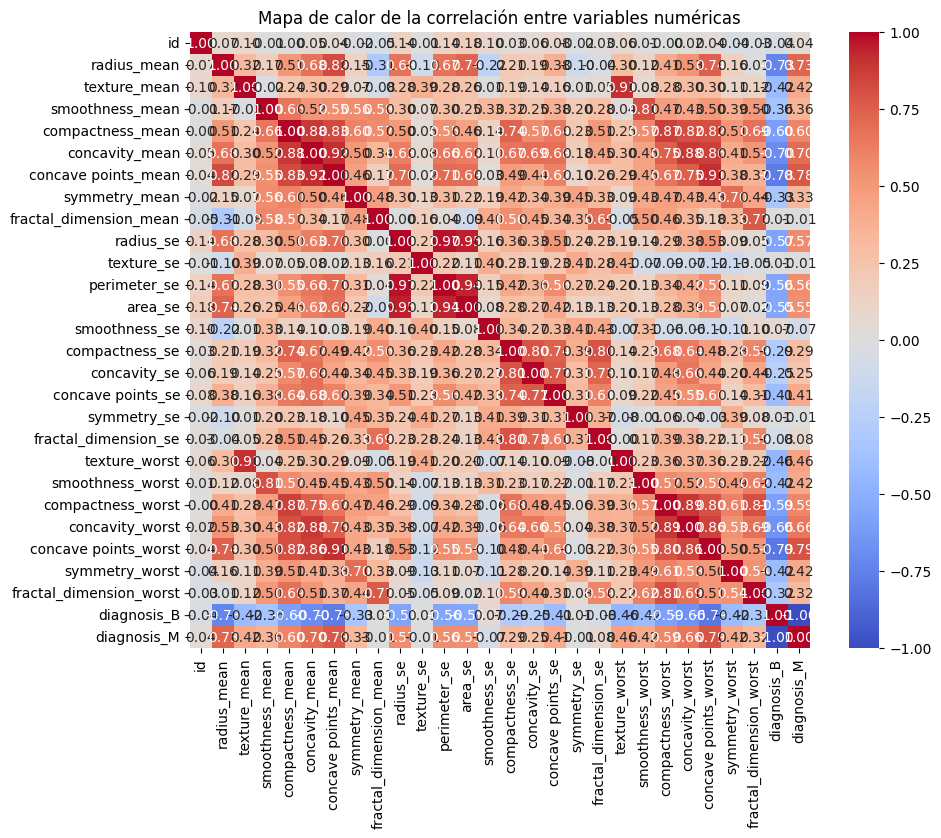

In [ ]:
# Codificación One-Hot para variables categóricas
data_encoded2 = pd.get_dummies(data)

correlation_matrix_processed = data_encoded2.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_processed, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Mapa de calor de la correlación entre variables numéricas')
plt.show()


In [ ]:
# Definir un umbral para la correlación
umbral = 0.9

# Iterar sobre la matriz de correlación
for i in range(len(correlation_matrix_processed.columns)):
    for j in range(i+1, len(correlation_matrix_processed.columns)):
        correlation = correlation_matrix_processed.iloc[i, j]
        feature1 = correlation_matrix_processed.columns[i]
        feature2 = correlation_matrix_processed.columns[j]
        if abs(correlation) >= umbral:
            print(f"{feature1} y {feature2} tienen una correlación de {correlation}")


texture_mean y texture_worst tienen una correlación de 0.912044588840421
concavity_mean y concave points_mean tienen una correlación de 0.9213910263788588
concave points_mean y concave points_worst tienen una correlación de 0.9101553142985918
radius_se y perimeter_se tienen una correlación de 0.9727936770160764
radius_se y area_se tienen una correlación de 0.951830112110991
perimeter_se y area_se tienen una correlación de 0.9376554069544157
diagnosis_B y diagnosis_M tienen una correlación de -1.0000000000000002


Podemos comprobar que quedan muchas menos que antes, las dos de diagnosis las mantenemos. Pero, las demás son el radio y el perímetro o el radio y el área o el área y el perímetro. Como todas las parejas pueden explicarse con solo una de las dos partes vamos a eliminar 'concavity_mean, 'perimeter_se', 'area_se', 'texture_mean' y 'concave points_mean'.

         id  radius_mean  smoothness_mean  compactness_mean  symmetry_mean  \
0    842302        17.99          0.11840           0.27760         0.2419   
1    842517        20.57          0.08474           0.07864         0.1812   
2  84300903        19.69          0.10960           0.15990         0.2069   
3  84348301        11.42          0.14250           0.28390         0.2597   
4  84358402        20.29          0.10030           0.13280         0.1809   

   fractal_dimension_mean  radius_se  texture_se  smoothness_se  \
0                 0.07871     1.0950      0.9053       0.006399   
1                 0.05667     0.5435      0.7339       0.005225   
2                 0.05999     0.7456      0.7869       0.006150   
3                 0.09744     0.4956      1.1560       0.009110   
4                 0.05883     0.7572      0.7813       0.011490   

   compactness_se  ...  fractal_dimension_se  texture_worst  smoothness_worst  \
0         0.04904  ...              0.006193   

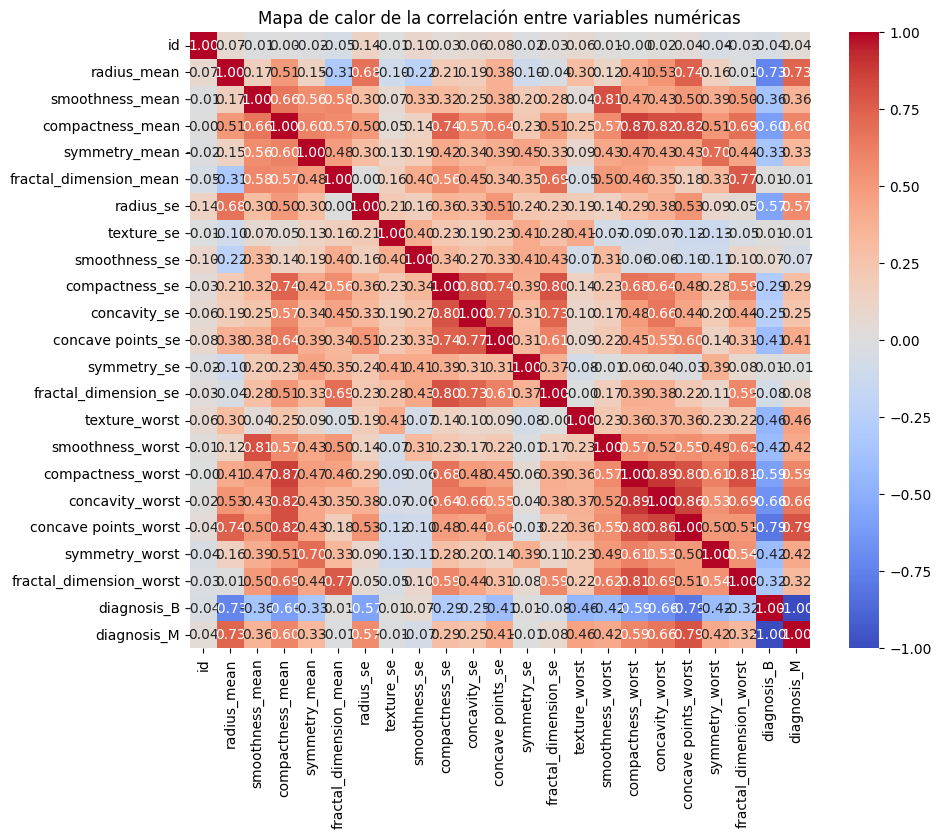

In [ ]:
# Eliminar las características 'concavity_mean', 'perimeter_se' y 'area_se' de data_processed
data = data_encoded2.drop(columns=['concavity_mean', 'perimeter_se', 'area_se', 'texture_mean', 'concave points_mean'])

# Mostrar la base de datos después de eliminar las características
print(data.head())

# Codificación One-Hot para variables categóricas
data_encoded2 = pd.get_dummies(data)

correlation_matrix_processed2 = data_encoded2.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_processed2, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Mapa de calor de la correlación entre variables numéricas')
plt.show()

Ya hemos llegado a una matriz de correlación mucho mejor que la inicial donde no hay ninguna correlación fuerte, superior a 0.9. Excepto diagnosis B y diagnosis M que son las variables a predecir y tienen una correlación inversa perfecta. Esto ocurre porque no hay NA y siempre toma el valor de una de las dos. Puede ser un tumor Maligno o Benigno.

Para continuar, podemos eliminar la columna de id porque python asigna un id a cada columna.

In [ ]:
# Umbral para la correlación
umbral = 0.9

# Iterar sobre la matriz de correlación
for i in range(len(correlation_matrix_processed2.columns)):
    for j in range(i+1, len(correlation_matrix_processed2.columns)):
        correlation = correlation_matrix_processed2.iloc[i, j]
        feature1 = correlation_matrix_processed2.columns[i]
        feature2 = correlation_matrix_processed2.columns[j]
        if abs(correlation) >= umbral:
            print(f"{feature1} y {feature2} tienen una correlación de {correlation}")

data = data.drop(columns=['id'])
data.head()

diagnosis_B y diagnosis_M tienen una correlación de -1.0000000000000002


radius_mean  smoothness_mean  compactness_mean  symmetry_mean  \
0        17.99          0.11840           0.27760         0.2419   
1        20.57          0.08474           0.07864         0.1812   
2        19.69          0.10960           0.15990         0.2069   
3        11.42          0.14250           0.28390         0.2597   
4        20.29          0.10030           0.13280         0.1809   

   fractal_dimension_mean  radius_se  texture_se  smoothness_se  \
0                 0.07871     1.0950      0.9053       0.006399   
1                 0.05667     0.5435      0.7339       0.005225   
2                 0.05999     0.7456      0.7869       0.006150   
3                 0.09744     0.4956      1.1560       0.009110   
4                 0.05883     0.7572      0.7813       0.011490   

   compactness_se  concavity_se  ...  fractal_dimension_se  texture_worst  \
0         0.04904       0.05373  ...              0.006193          17.33   
1         0.01308       0.01860  ...              0.003532          23.41   
2         0.04006       0.03832  ...              0.004571          25.53   
3         0.07458       0.05661  ...              0.009208          26.50   
4         0.02461       0.05688  ...              0.005115          16.67   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  diagnosis_B  diagnosis_M  
0          0.4601                  0.11890        False         True  
1          0.2750                  0.08902        False         True  
2          0.3613                  0.08758        False         True  
3          0.6638                  0.17300        False         True  
4          0.2364                  0.07678        False         True  

[5 rows x 22 columns]

Por último, vamos a hacer 3 valores los que miden el área, el diámetro y la compacidad categóricos asignando 3 valores distintos a cada una. Para ello, vamos a dividir el rango de cada variable en 3 y asignaremos 'bajo', 'medio' y 'alto' a los distintos rangos.

In [ ]:
# Selección de las que se van a convertir en categóricas 'area_mean', 'perimeter_mean' y 'compactness_mean'
columnas_relevantes = ['radius_mean', 'compactness_mean', 'radius_se', 'compactness_se', 'compactness_worst']

# Crear una copia del DataFrame original
data_transformado = data.copy()

# Iterar sobre las columnas relevantes
for columna in columnas_relevantes:
    # Calcular los terciles de la columna actual
    terciles = pd.qcut(data_transformado[columna], q=3, labels=['Bajo', 'Medio', 'Alto'])
    # Reemplazar los valores originales con los terciles calculados
    data_transformado[columna] = terciles

# Mostrar cómo quedan los datos después de la transformación
print(data_transformado.head())



  radius_mean  smoothness_mean compactness_mean  symmetry_mean  \
0        Alto          0.11840             Alto         0.2419   
1        Alto          0.08474            Medio         0.1812   
2        Alto          0.10960             Alto         0.2069   
3        Bajo          0.14250             Alto         0.2597   
4        Alto          0.10030             Alto         0.1809   

   fractal_dimension_mean radius_se  texture_se  smoothness_se compactness_se  \
0                 0.07871      Alto      0.9053       0.006399           Alto   
1                 0.05667      Alto      0.7339       0.005225           Bajo   
2                 0.05999      Alto      0.7869       0.006150           Alto   
3                 0.09744      Alto      1.1560       0.009110           Alto   
4                 0.05883      Alto      0.7813       0.011490          Medio   

   concavity_se  ...  fractal_dimension_se  texture_worst  smoothness_worst  \
0       0.05373  ...              0.0

Ahora vamos a aplicar el algoritmo de clasificación con distintas medidas de desorden. Primero tendremos que convertir a one-hot las variables categóricas y luego aplicaremos GINI y la entropía. Cuando tengamos los resultados compararemos el error de ambos y dibujaremos los árboles.

In [ ]:
# Convertir variables categóricas en variables dummy (one-hot encoding)
X_transformado = pd.get_dummies(data_transformado.drop(columns=['diagnosis_B', 'diagnosis_M']))

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformado, data_transformado['diagnosis_M'], test_size=0.2, random_state=42)

# Clasificador de árbol de decisión con criterio de Gini
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
error_gini = 1 - accuracy_score(y_test, y_pred_gini)
print("Error del clasificador con criterio de Gini:", error_gini)

# Clasificador de árbol de decisión con criterio de Entropía
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)
error_entropy = 1 - accuracy_score(y_test, y_pred_entropy)
print("Error del clasificador con criterio de Entropía:", error_entropy)


Error del clasificador con criterio de Gini: 0.052631578947368474
Error del clasificador con criterio de Entropía: 0.06140350877192979


Ambos clasificadores dan un error muy bajo. Aunque el clasificador gini tiene un error un poco menor, son muy similares. Para decidir cuál es el mejor usaremos el recall, que cuenta con la sensibilidad del modelo. Es decir, el recall puede variar entre 0 y 1 donde 0 es el peor caso y 1 indica que es perfecto, no hay falsos positivos, todos los positivos son correctos. En este caso, es importante verificar esto, ya que en temas de medicina dar un falso positivo puede ser peligroso.

In [ ]:
# Calcular el recall para el clasificador con criterio de Gini
recall_gini = recall_score(y_test, y_pred_gini)

# Calcular el recall para el clasificador con criterio de Entropía
recall_entropy = recall_score(y_test, y_pred_entropy)

print("Recall para el clasificador con criterio de Gini:", recall_gini)
print("Recall para el clasificador con criterio de Entropía:", recall_entropy)

Recall para el clasificador con criterio de Gini: 0.9302325581395349
Recall para el clasificador con criterio de Entropía: 0.9302325581395349


Se ve que ambos tienen el mismo recall y muy cercano a 1, por lo que son muy buenos clasificadores. Sin embargo, el clasificador de gini tiene un error ligeramente menor, por lo que nos quedaremos con este clasificador como el mejor.

Para visualizar gráficamente los resultados usaremos árboles de decisión:

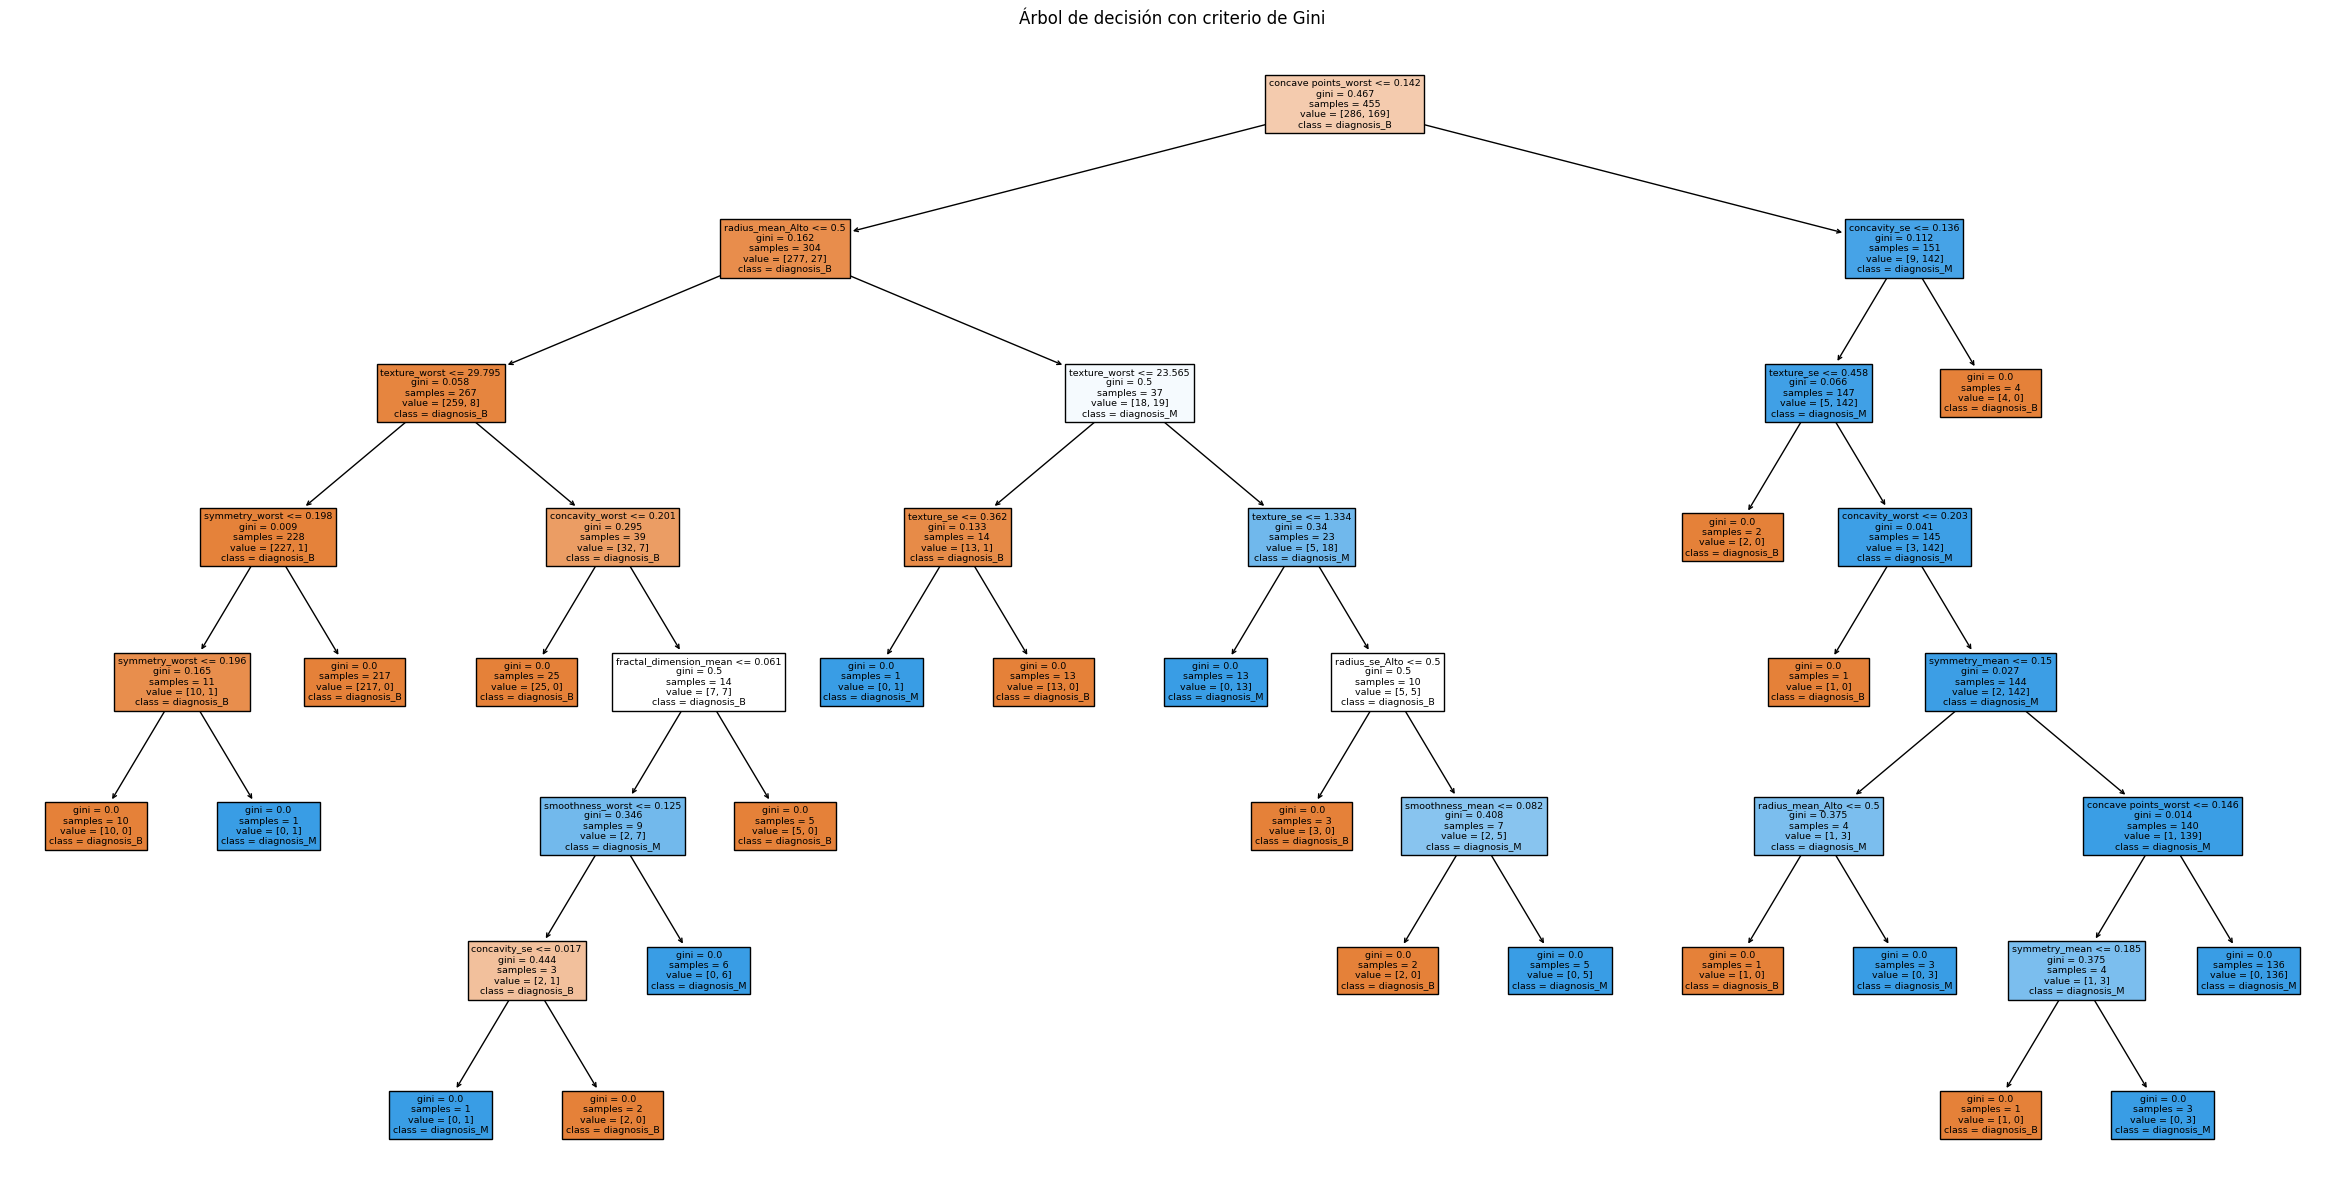

In [ ]:
plt.figure(figsize=(30, 15))

# Plot del árbol de decisión con criterio de Gini
plot_tree(dt_gini, filled=True, feature_names=X_transformado.columns, class_names=['diagnosis_B', 'diagnosis_M'])
plt.title('Árbol de decisión con criterio de Gini')

plt.show()

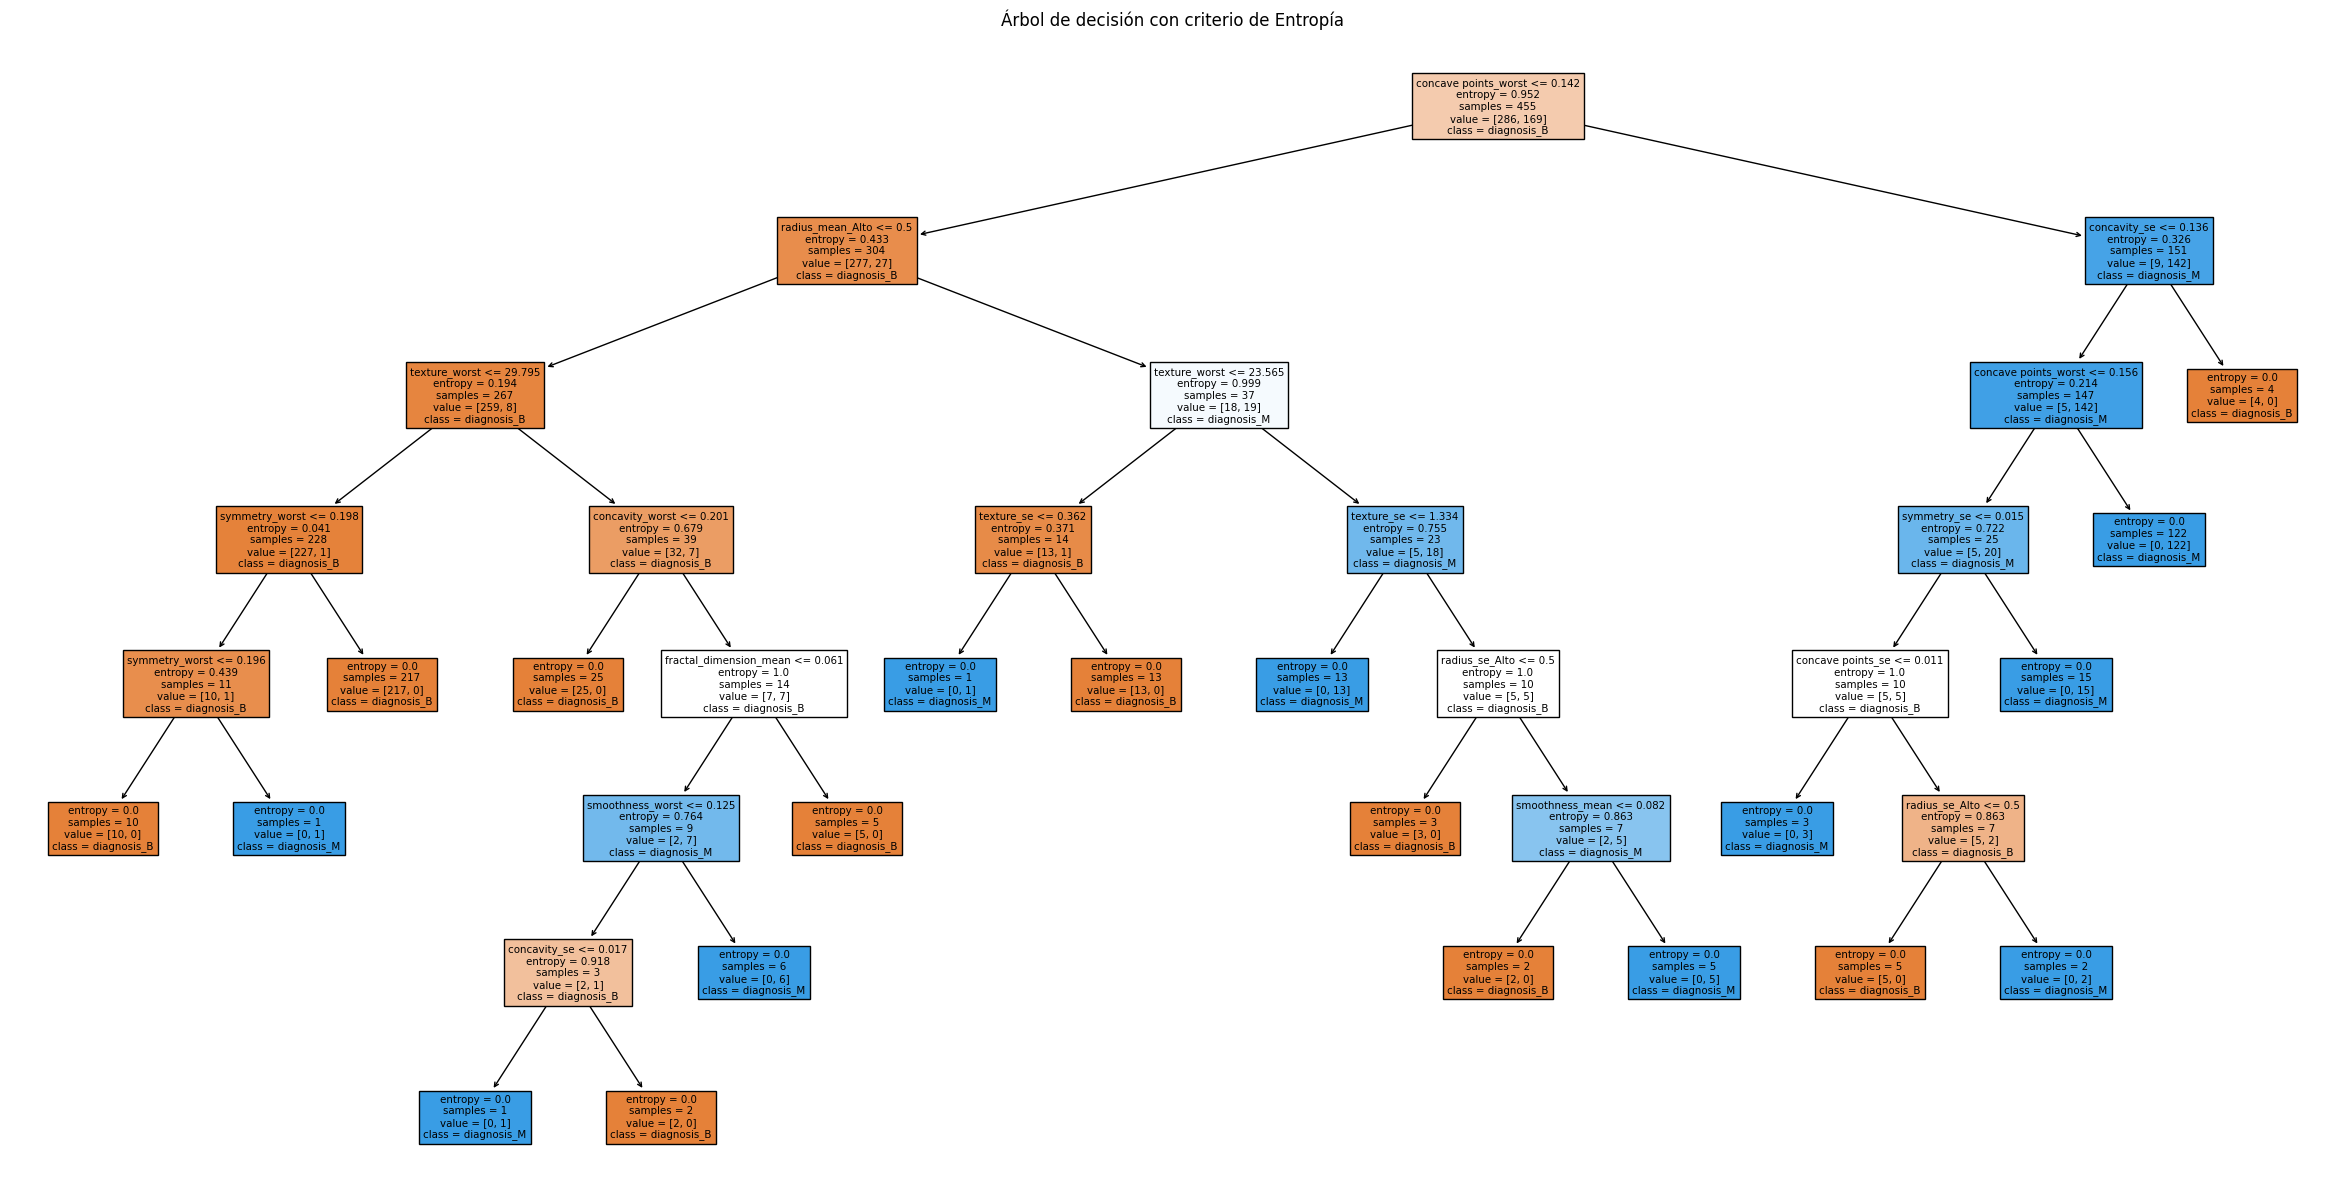

In [ ]:
# Plot del árbol de decisión con criterio de Entropía
plt.figure(figsize=(30, 15))

plot_tree(dt_entropy, filled=True, feature_names=X_transformado.columns, class_names=['diagnosis_B', 'diagnosis_M'])
plt.title('Árbol de decisión con criterio de Entropía')

plt.show()

Para continuar, vamos a tomar un 10% de los datos para que las reglas sean más fáciles de ver. De las reglas que se obtengan se tomarán dos reglas que cubran muchos casos, es decir que generalicen más y dos reglas que cubran pocos casos, que sean más especializadas. Para ver las reglas usaremos un árbol de decisión, ya que cuanto más profundas sean menos generales serán y cuanto menos profundas sean menos específicas serán.

In [ ]:
# Tomar un 10% de los datos para reducir el tamaño del árbol
data_sampled = data.sample(frac=0.3, random_state=42)

# Dividir los datos en características (X) y variable objetivo (y)
X = pd.get_dummies(data_sampled.drop(columns=['diagnosis_B', 'diagnosis_M']))
y = data_sampled['diagnosis_M']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un árbol de decisión
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Extraer las reglas del árbol de decisión
tree_rules = export_text(dt, feature_names=X.columns.tolist())

# Imprimir las reglas
print(tree_rules)



|--- radius_mean <= 15.06
|   |--- concave points_worst <= 0.12
|   |   |--- class: False
|   |--- concave points_worst >  0.12
|   |   |--- texture_worst <= 27.29
|   |   |   |--- radius_mean <= 13.47
|   |   |   |   |--- class: False
|   |   |   |--- radius_mean >  13.47
|   |   |   |   |--- concave points_se <= 0.01
|   |   |   |   |   |--- class: True
|   |   |   |   |--- concave points_se >  0.01
|   |   |   |   |   |--- class: False
|   |   |--- texture_worst >  27.29
|   |   |   |--- class: True
|--- radius_mean >  15.06
|   |--- symmetry_se <= 0.01
|   |   |--- class: False
|   |--- symmetry_se >  0.01
|   |   |--- class: True



In [ ]:
tree_rules = export_text(dt, feature_names=list(X.columns))

rules = tree_rules.splitlines()

# Variables para almacenar las reglas generales y específicas
general_rules = []
specific_rules = []

# Definir la función calculate_depth
def calculate_depth(rule):
    return rule.count('|   ')

# Recorrer las reglas y clasificarlas
for rule in rules:
    if 'class' in rule:
        depth = calculate_depth(rule)

        # Asumir que las reglas en la raíz o a un nivel de profundidad son generales
        if depth >= 3:
            general_rules.append(rule)
        # Asumir que las reglas con una profundidad mayor son más específicas
        else:
            specific_rules.append(rule)

# Ordenar las reglas de menor a mayor profundidad para generalidad y viceversa para especificidad
general_rules.sort(key=calculate_depth)  # Orden ascendente para generalidad
specific_rules.sort(key=calculate_depth, reverse=True)  # Orden descendente para especificidad

# Seleccionar las dos reglas menos generales y las dos menos específicas
two_least_general_rules = general_rules[-2:]  # Últimas dos reglas menos generales
two_least_specific_rules = specific_rules[:2]  # Primeras dos reglas menos específicas

# Imprimir las reglas seleccionadas
print("Dos reglas que generalizan menos:")
for rule in two_least_general_rules:
    print(rule)

print("\nDos reglas que especializan menos:")
for rule in two_least_specific_rules:
    print(rule)

Dos reglas que generalizan menos:
|   |   |   |   |   |--- class: True
|   |   |   |   |   |--- class: False

Dos reglas que especializan menos:
|   |   |--- class: False
|   |   |--- class: False


Para las dos reglas que menos generalizan tenemos una de profundidad 6 que predice que diagnosis_M = True, por lo que diagnostica un cáncer maligno, la otra regla tiene profundidad 6 también y predice que el cancer es benigno.

Regla 1:

radius_mean <= 15.06 and concave points_worst > 0.12 and texture_worst <= 27.29 and radius_mean > 13.47 and concave points_se <= 0.01 then class = diagnosis_M

Regla 2:

radius_mean <= 15.06 and concave points_worst >  0.12 and texture_worst <= 27.29 and radius_mean >  13.47 and concave points_se >  0.01 then class = diagnosis_B

Estas dos reglas son prácticamente iguales, pero en la última condición cambia concave points_se, si es menor que 0.01 será un cáncer maligno y en caso contrario benigno.

En cuanto a las reglas que especializan menos tenemos ambas de profundidad 3 y predicen que el cáncer es benigno. Está claro que la profundidad de estas reglas debía ser menor que las anteriores. Ya que, si especializan poco estarán al principio del árbol, serán generales.


Regla 1:

radius_mean <= 15.06 and concave points_worst <= 0.12 then class = diagnosis_B


Regla 2:

radius_mean > 15.06 and symmetry_se <= 0.01 then class = diagnosis_B







Por lo tanto, si el valor de 'diagnosis_M' es False, significa que el tumor es benigno. Si el valor es True, significa que el tumor es maligno.

### Clasificación de nuevos individuos:

Ahora se creará un nuevo dataset con 5 individuos y se clasificará si tienen o no un cáncer maligno.

In [ ]:
np.random.seed(42)

# Generar 5 individuos aleatorios
random_individuals = {}
for feature in X_transformado.columns:
    random_individuals[feature] = np.random.uniform(X_transformado[feature].min(), X_transformado[feature].max(), size=5)

# Crear el DataFrame con los individuos aleatorios
new_data = pd.DataFrame(random_individuals)
print(new_data)

# Hacer predicciones
predictions_new_data = dt_gini.predict(new_data)

pd.set_option('display.max_columns', None)

# Mostrar las predicciones
print(predictions_new_data)

   smoothness_mean  symmetry_mean  fractal_dimension_mean  texture_se  \
0         0.094118       0.136887                0.050937    1.190069   
1         0.157941       0.117501                0.096011    1.736835   
2         0.133713       0.277503                0.089484    2.734618   
3         0.118943       0.225021                0.060042    2.314665   
4         0.069912       0.246198                0.058593    1.677954   

   smoothness_se  concavity_se  concave points_se  symmetry_se  \
0       0.019712      0.310930           0.032072     0.065333   
1       0.005816      0.079071           0.009002     0.029530   
2       0.010307      0.203637           0.003434     0.014823   
3       0.012490      0.234596           0.050092     0.056509   
4       0.015129      0.018394           0.050976     0.039163   

   fractal_dimension_se  texture_worst  smoothness_worst  concavity_worst  \
0              0.004427      36.877836          0.217994         1.154187   
1         

Se han predicho dos casos falsos y 3 verdaderos, lo que implica que 3 de los 5 individuos tienen un cáncer maligno, según el clasificador de gini entrenado anteriormente.

In [ ]:
print(new_data.iloc[0])


smoothness_mean             0.094118
symmetry_mean               0.136887
fractal_dimension_mean      0.050937
texture_se                  1.190069
smoothness_se               0.019712
concavity_se                0.310930
concave points_se           0.032072
symmetry_se                 0.065333
fractal_dimension_se        0.004427
texture_worst              36.877836
smoothness_worst            0.217994
concavity_worst             1.154187
concave points_worst        0.113105
symmetry_worst              0.431810
fractal_dimension_worst     0.172776
radius_mean_Bajo            0.729007
radius_mean_Medio           0.863103
radius_mean_Alto            0.325183
compactness_mean_Bajo       0.119594
compactness_mean_Medio      0.493796
compactness_mean_Alto       0.031429
radius_se_Bajo              0.249292
radius_se_Medio             0.289751
radius_se_Alto              0.871461
compactness_se_Bajo         0.807440
compactness_se_Medio        0.427108
compactness_se_Alto         0.417411
c

Se puede comprobar que las predicciones son correctas siguiendo el camino del árbol. Para verlo usamos al primer individuo que se ha generado aleatoriamente.

La primera característica 'concave points_worst' = 0.113105, que es menor que 0.142 (primera regla). Esto lleva a radius_mean_Alto <= 0.5, en este caso es 0.32, por lo que sigue esta regla también. Para continuar texture_worst es >= que 29.795, la siguiente regla es concavity_worst que es mayor que 0.201. Luego compara fractal_dimension_mean y resulta ser menor que 0.061, por lo que la clase que debería predecir es diagnosis_M y efectivamente devuelve 'True', por lo que el individuo 0 tiene un cáncer maligno.

## Práctica 2 (TCGA)

TCGA (The Cancer Genome Atlas) es un proyecto colaborativo dirigido por el Instituto Nacional del Cáncer (NCI) y el Instituto Nacional de Investigación del Genoma Humano (NHGRI) en los Estados Unidos. Su objetivo principal es caracterizar exhaustivamente las alteraciones genómicas en el cáncer mediante el análisis de grandes conjuntos de datos de pacientes con cáncer. Se pretende crear un clasificador de cáncer que tenga en cuenta las probabilidades de pertenecer a una clase dependiendo de las distintas variables y sus valores.

Usa scikit-learn junto con las librerías que necesites para resolver las siguientes cuestiones.

TCGA (The Cancer Genome Atlas) es un proyecto colaborativo dirigido por el Instituto Nacional del Cáncer (NCI) y el Instituto Nacional de Investigación del Genoma Humano (NHGRI) en los Estados Unidos. Su objetivo principal es caracterizar exhaustivamente las alteraciones genómicas en el cáncer mediante el análisis de grandes conjuntos de datos de pacientes con cáncer. El presente documento tiene el objetivo de hallar un clasificador adecuado que permita asignar a cada paciente, de acuerdo a su perfil y condiciones médicas, la correspondiente clase de tumor cerebral presente en su organismo cerebrcon la mayor precisión posible.

Para el estudio, se seleccionará como recurso la siguiente base de datos. En ella, se recogen los históricos de pacientes que han sufrido cáncer. La información presente incluye datos de índole demográfica, como la edad en el momento de diagnóstico o el sexo, así como los resultados del análisis de la presencia de diferentes genes. A continuación, se detallan estos atributos:

**Identificadores**
* Project. Código identificador del grupo de análisis según el glioma.
* Case_ID. Código indentificador del caso del paciente.

**Datos del paciente**
* Grade. Grao de gravedad del glioma.
* Gender. Sexo del paciente.
* Age_at_diagnosis. Edad del paciente en el momento de diagnóstico expresada en años y días.
* Primary_Diagnosis. Diagnóstico primario, tipo de cáncer específico.
* Race. Origen étnico.

**Resultados clínicos**

Se compone de la evaluación de 20 tipos diferentes de genes, entre los que se puede encontrar:

* IDH1. Proteína encargada de la descomposición de grasas para la producción de energía, así como protectora de las células de moléculas dañinas.
* TP53. Gen "supresor de tumores", encargado de la producción de proteínas que controlen la división y destrucción de células.

In [ ]:
file_path = 'TCGA.csv'

# Guarda el archivo csv en el DataFrame
df = pd.read_csv(file_path)
# Visualización inicial
df.head()

Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
0   LGG  TCGA-LGG  TCGA-DU-8164    Male  51 years 108 days   
1   LGG  TCGA-LGG  TCGA-QH-A6CY    Male  38 years 261 days   
2   LGG  TCGA-LGG  TCGA-HW-A5KM    Male   35 years 62 days   
3   LGG  TCGA-LGG  TCGA-E1-A7YE  Female  32 years 283 days   
4   LGG  TCGA-LGG  TCGA-S9-A6WG    Male  31 years 187 days   

         Primary_Diagnosis   Race     IDH1         TP53         ATRX  ...  \
0   Oligodendroglioma, NOS  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1             Mixed glioma  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
2         Astrocytoma, NOS  white  MUTATED      MUTATED      MUTATED  ...   
3  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   
4  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   

         FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
2  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
3  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
4  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   

       SMARCA4       GRIN2A         IDH2         FAT4       PDGFRA  
0  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
1  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
2  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
3  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  
4  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  

[5 rows x 27 columns]

### Limpieza de datos

**Duplicados**

Antes de proceder con la clasificación, se comprobará la validez y calidad de los datos. Para ello, se estudiará si existe duplicidad en los registros.

In [ ]:
# Obtener el número de filas en el DataFrame
num_filas_orig = len(df)

# Mostrar el resultado
print(f"Número de filas en el DataFrame: {num_filas_orig}")

Número de filas en el DataFrame: 862


In [ ]:
df = df.drop_duplicates()
num_dupl = num_filas_orig - len(df)

print(f'Se han eliminado {num_dupl} duplicados.\nNúmero de registros actualizado: {len(df)}')

Se han eliminado 0 duplicados.
Número de registros actualizado: 862


**Valores NaN**

No se han localizado registros duplicados. No obstante, resulta asimismo crucial estudiar la presencia de valores NaN o campos vacíos en la base de datos.

In [ ]:
# Calcula la cantidad de NaN en cada columna
nan_count = df.isna().sum()

# Imprime el resultado
print("NaN por columna:")
print(nan_count)

NaN por columna:
Grade                0
Project              0
Case_ID              0
Gender               0
Age_at_diagnosis     0
Primary_Diagnosis    0
Race                 0
IDH1                 0
TP53                 0
ATRX                 0
PTEN                 0
EGFR                 0
CIC                  0
MUC16                0
PIK3CA               0
NF1                  0
PIK3R1               0
FUBP1                0
RB1                  0
NOTCH1               0
BCOR                 0
CSMD3                0
SMARCA4              0
GRIN2A               0
IDH2                 0
FAT4                 0
PDGFRA               0
dtype: int64


Una vez se ha podido incluir la ausencia de datos vacíos se continúa con la preparación de los datos con el fin de que su tratamiento posterior en el proceso de clasificación sea óptimo. Para ello, se analizará si todos los atributos de la tabla contienen información valiosa o, por el contrario, se dan redundancias.

Se observa que las columnas Grade y Project podrían estar dando la misma información.

In [ ]:
# Obtener valores únicos de la columna1
valores_unicos_columna1 = df['Grade'].unique()

# Obtener valores únicos de la columna2
valores_unicos_columna2 = df['Project'].unique()

print("Valores únicos de la columna 1:", valores_unicos_columna1)
print()
print("Valores únicos de la columna 2:", valores_unicos_columna2)

Valores únicos de la columna 1: ['LGG' 'GBM']

Valores únicos de la columna 2: ['TCGA-LGG' 'TCGA-GBM']


In [ ]:
# Se comprueba si los pacientes coinciden en ambas columnas para cada clase
lgg_grade = df[df['Grade'] == 'LGG'].index.tolist()
lgg_project = df[df['Project'] == 'TCGA-LGG'].index.tolist()

gbm_grade = df[df['Grade'] == 'GBM'].index.tolist()
gbm_project = df[df['Project'] == 'TCGA-GBM'].index.tolist()

if lgg_grade == lgg_project and gbm_grade == gbm_project:
  print('Las dos columnas contienen la misma información para todos los registros')

Las dos columnas contienen la misma información para todos los registros


Se ha comprobado la hipótesis inicial, luego se eliminará la columna Project.

In [ ]:
df = df.drop(columns=['Project'])
print(df.head())

  Grade       Case_ID  Gender   Age_at_diagnosis        Primary_Diagnosis  \
0   LGG  TCGA-DU-8164    Male  51 years 108 days   Oligodendroglioma, NOS   
1   LGG  TCGA-QH-A6CY    Male  38 years 261 days             Mixed glioma   
2   LGG  TCGA-HW-A5KM    Male   35 years 62 days         Astrocytoma, NOS   
3   LGG  TCGA-E1-A7YE  Female  32 years 283 days  Astrocytoma, anaplastic   
4   LGG  TCGA-S9-A6WG    Male  31 years 187 days  Astrocytoma, anaplastic   

    Race     IDH1         TP53         ATRX         PTEN  ...        FUBP1  \
0  white  MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...      MUTATED   
1  white  MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
2  white  MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
3  white  MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
4  white  MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   

           RB1       NOTCH1         BCOR        CSMD3      SMARCA4  

Por otro lado, se analizarán los valores que las distintas variables categóricas toman. Para ello, se comienza por la variable relacionada con el sexo del paciente.

In [ ]:
# Valores únicos del atributo
diagnosis = df['Gender'].unique()
print(diagnosis)

['Male' 'Female' '--']


Se puede ver que uno de los valores asociados a este campo es '--'. Se observan los pacientes caracterizados por tomar este valor para estudiar la viabilidad de la inclusión de sus casos en nuestro estudio.

In [ ]:
registros_cumplen_condicion = df[df['Gender'] == '--']

# Mostrar los registros que cumplen la condición
print("Registros que cumplen la condición:")
print(registros_cumplen_condicion)

Registros que cumplen la condición:
    Grade       Case_ID Gender Age_at_diagnosis Primary_Diagnosis Race  \
41    LGG  TCGA-R8-A6YH     --               --                --   --   
671   GBM  TCGA-28-2501     --               --                --   --   
706   GBM  TCGA-28-2510     --               --                --   --   
794   GBM  TCGA-16-1048     --               --                --   --   

            IDH1         TP53         ATRX         PTEN  ...        FUBP1  \
41       MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
671  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
706  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  ...  NOT_MUTATED   
794  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED   

             RB1       NOTCH1         BCOR        CSMD3      SMARCA4  \
41   NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
671  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MU

Se ve que el mismo campo desconocido se repite para las variables ```Age_at_diagnosis```, ```Primary_Diagnosis``` y ```Race```. Se llega a la conclusión de que la denotación de estos campos con **'--'** significa lo mismo que los valores NaN. Luego se sustituyen en la tabla y se eliminan los registros cuya información contenga estos campos vacíos.

In [ ]:
df.replace('--', pd.NA, inplace=True)
# Eliminar las filas con los índices especificados
df = df.dropna()

num_nan = num_filas_orig - len(df)
print(f'Se han eliminado {num_nan} filas.\nNúmero de registros actualidado: {len(df)}')

Se han eliminado 5 filas.
Número de registros actualidado: 857


Por último, se comprueba que los atributos categóricos sobre el paciente presentan valores válidos antes de continuar con el estudio.

In [ ]:
columns = ['Gender', 'Primary_Diagnosis', 'Race']

for col in columns:
  values = df[col].unique()
  print(values)
  print()

['Male' 'Female']

['Oligodendroglioma, NOS' 'Mixed glioma' 'Astrocytoma, NOS'
 'Astrocytoma, anaplastic' 'Oligodendroglioma, anaplastic' 'Glioblastoma']

['white' 'asian' 'black or african american' 'not reported'
 'american indian or alaska native']



### Transformación de datos

Se ha observado que la edad en el momento de diagnóstico está guardada como datos de tipo str, lo que complica la tarea de clasificación ya que la inmensa diversidad de valores entre pacientes provoca que el atributo tenga un comportamiento más cercano al de una variable continua. Procedemos a extraer la información valiosa y presentarla como valores numéricos. Para ello, se generarán dos nuevas columnas que guardarán los años y los días en los que se divide la columna *Age_at_diagnosis*.

In [ ]:
print(type(df['Age_at_diagnosis'][0]))

<class 'str'>


In [ ]:
# Función para extraer el número de años de una cadena
def extraer_años(cadena):
    patron = r"(\d+) years"
    resultado = re.search(patron, cadena)
    if resultado:
        años = int(resultado.group(1))
        return años
    else:
        return None

# Función para extraer el número de días de una cadena
def extraer_dias(cadena):
    patron = r"(\d+) days"
    resultado = re.search(patron, cadena)
    if resultado:
        años = int(resultado.group(1))
        return años
    else:
        return 0

# Aplicar la función a la columna del DataFrame
years = df['Age_at_diagnosis'].apply(lambda x: extraer_años(x))
days = df['Age_at_diagnosis'].apply(lambda x: extraer_dias(x))

df.insert(loc=4, column='Years', value=years)
df.insert(loc=5, column='Days', value=days)

print(df)

    Grade       Case_ID  Gender   Age_at_diagnosis  Years  Days  \
0     LGG  TCGA-DU-8164    Male  51 years 108 days     51   108   
1     LGG  TCGA-QH-A6CY    Male  38 years 261 days     38   261   
2     LGG  TCGA-HW-A5KM    Male   35 years 62 days     35    62   
3     LGG  TCGA-E1-A7YE  Female  32 years 283 days     32   283   
4     LGG  TCGA-S9-A6WG    Male  31 years 187 days     31   187   
..    ...           ...     ...                ...    ...   ...   
857   GBM  TCGA-19-5959  Female  77 years 325 days     77   325   
858   GBM  TCGA-16-0846    Male   85 years 65 days     85    65   
859   GBM  TCGA-28-1746  Female  77 years 178 days     77   178   
860   GBM  TCGA-32-2491    Male  63 years 121 days     63   121   
861   GBM  TCGA-06-2557    Male  76 years 221 days     76   221   

           Primary_Diagnosis                       Race         IDH1  \
0     Oligodendroglioma, NOS                      white      MUTATED   
1               Mixed glioma                      w

#### Evaluación de datos incorrectos

De acuerdo a los datos recogidos, el único atributo cuyos valores pueden resultar conflictivos con la realidad es el referido a la edad del paciente. Se procede a comprobar si se han atribuido valores negativos a algún registro.

In [ ]:
errores = df[(df['Years'] < 0) | (df['Days'] < 0)].count()

if errores.any():
  print('Hay datos erróneos')
else:
  print('No hay ningún problema')

No hay ningún problema


Una vez se ha comprobado su validez, se continúa con el estudio de la distribución de los datos con el fin de localizar si existen valores fuera de lo normal. Para ello, se recurre a representaciones gráficas. Vamos a aprovechar para hacer una primera estimación del perfil de edad que presentan los pacientes en función del grado de gravedad del glioma.

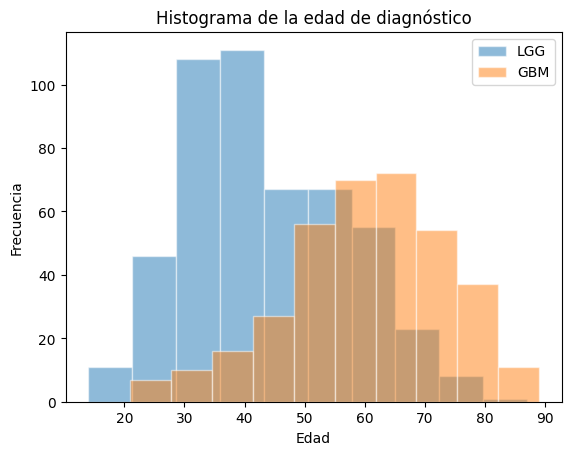

In [ ]:
# Filtrar el DataFrame para obtener las edades de diagnóstico para los grupos "lgg" y "gbm"
edades_lgg = df[df['Grade'] == 'LGG']['Years']
edades_gbm = df[df['Grade'] == 'GBM']['Years']

# Crear los histogramas
plt.hist(edades_lgg, bins=10, edgecolor='white', alpha=0.5, label='LGG')
plt.hist(edades_gbm, bins=10, edgecolor='white', alpha=0.5, label='GBM')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de la edad de diagnóstico')
plt.legend()
plt.show()

De acuerdo a los resultados obtenidos a partir de la visualización de la distribución de estos, se puede hacer una primera predicción sobre el perfil de los pacientes; los tumores de tipo LGG se presentan con mayor frecuencia en las personas más jóvenes, mientras que los pacientes de avanzada edad suelen asociarse a gliomas de mayor gravedad.

Asimismo, se puede observar que la clase GBM parece tener una presencia más limitada en la base de datos. Al tratarse de una tarea de clasificación, se comprueba si ambas clases están balanceadas o no.

In [ ]:
# Contar los registros que pertenecen a cada clase
conteo_lgg = (df['Grade'] == 'LGG').sum()
conteo_gbm = (df['Grade'] == 'GBM').sum()

# Mostrar el conteo
print("Cantidad de registros en la clase 'LGG':", conteo_lgg)
print("Cantidad de registros en la clase 'GBM':", conteo_gbm)

clase_max = max(conteo_lgg, conteo_gbm)
clase_min = min(conteo_lgg, conteo_gbm)

ratio = clase_max / clase_min

print(f'La clase mayoritaria supera a la minoritaria en un {round((ratio - 1)*100, 3)}%')

Cantidad de registros en la clase 'LGG': 497
Cantidad de registros en la clase 'GBM': 360
La clase mayoritaria supera a la minoritaria en un 38.056%


Se obtiene que la clase de aquellos diagnosticados con LGG o glioma de grado menor cuenta con alrededor de un 38.056% más de registros que la asociada al Glioblastoma Multiforme. Esto se habrá de tener en cuenta durante el proceso de clasificación.

Finalizada la limpieza y preparación de los datos, se procede al estudio gráfico de la información contenida en la tabla.

### Diagrama de tallos y hojas

(<Figure size 750x275 with 1 Axes>, <Axes: >)

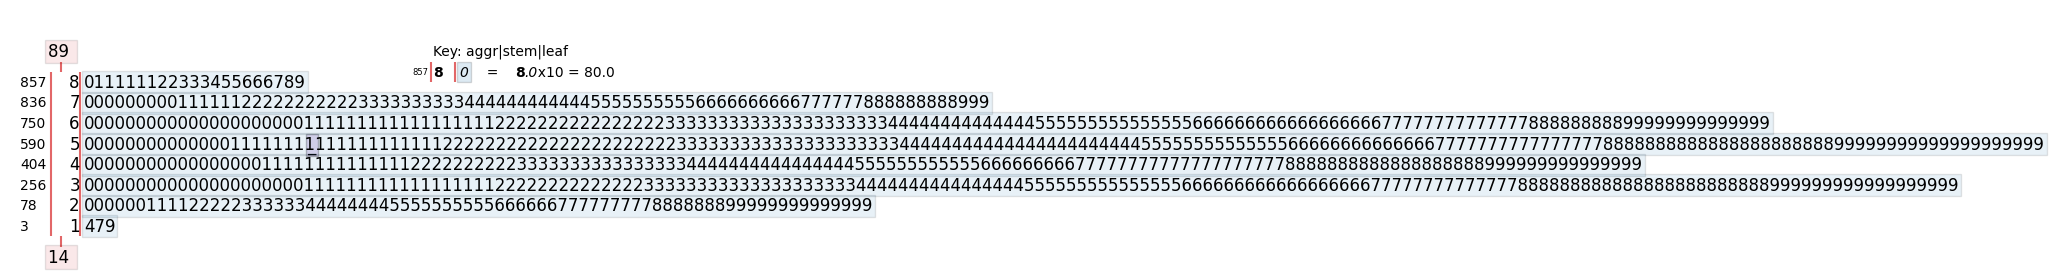

In [ ]:
# stem_graphic para el diagrama de tallos y hojas
stemgraphic.stem_graphic(df['Years'].tolist(), scale = 10)

In [ ]:
# Calcular los cuartiles de la columna 'Edad'
q1 = df['Years'].quantile(0.25)
q2 = df['Years'].quantile(0.5)
q3 = df['Years'].quantile(0.75)

# Función para asignar cada valor a su cuartil correspondiente
def asignar_cuartil(valor):
    if valor <= q1:
        return "Q1"
    elif valor <= q2:
        return "Q2"
    elif valor <= q3:
        return "Q3"
    else:
        return "Q4"

# Aplicar la función a la columna 'Edad' y asignar los resultados a una nueva columna 'Cuartil'
cuart = df['Years'].apply(asignar_cuartil)
df.insert(loc=6, column='Cuartil', value=cuart)

print(df)

    Grade       Case_ID  Gender   Age_at_diagnosis  Years  Days Cuartil  \
0     LGG  TCGA-DU-8164    Male  51 years 108 days     51   108      Q2   
1     LGG  TCGA-QH-A6CY    Male  38 years 261 days     38   261      Q1   
2     LGG  TCGA-HW-A5KM    Male   35 years 62 days     35    62      Q1   
3     LGG  TCGA-E1-A7YE  Female  32 years 283 days     32   283      Q1   
4     LGG  TCGA-S9-A6WG    Male  31 years 187 days     31   187      Q1   
..    ...           ...     ...                ...    ...   ...     ...   
857   GBM  TCGA-19-5959  Female  77 years 325 days     77   325      Q4   
858   GBM  TCGA-16-0846    Male   85 years 65 days     85    65      Q4   
859   GBM  TCGA-28-1746  Female  77 years 178 days     77   178      Q4   
860   GBM  TCGA-32-2491    Male  63 years 121 days     63   121      Q4   
861   GBM  TCGA-06-2557    Male  76 years 221 days     76   221      Q4   

           Primary_Diagnosis                       Race         IDH1  ...  \
0     Oligodendrogliom

#### Tablas de distribución

Por último, se mostrará la distribución de los datos de estudio en función de los diferentes atributos que los definen. Además, se aprovechará para presentar la distribución de los distintos valores de cada característica frente a las clases objetivo, con el fin de ilustrar la capacidad de cada atributo de clasificar individualmente la gravedad del glioma del paciente. En este caso, se recurrirá al empleo de diagramas de barras.



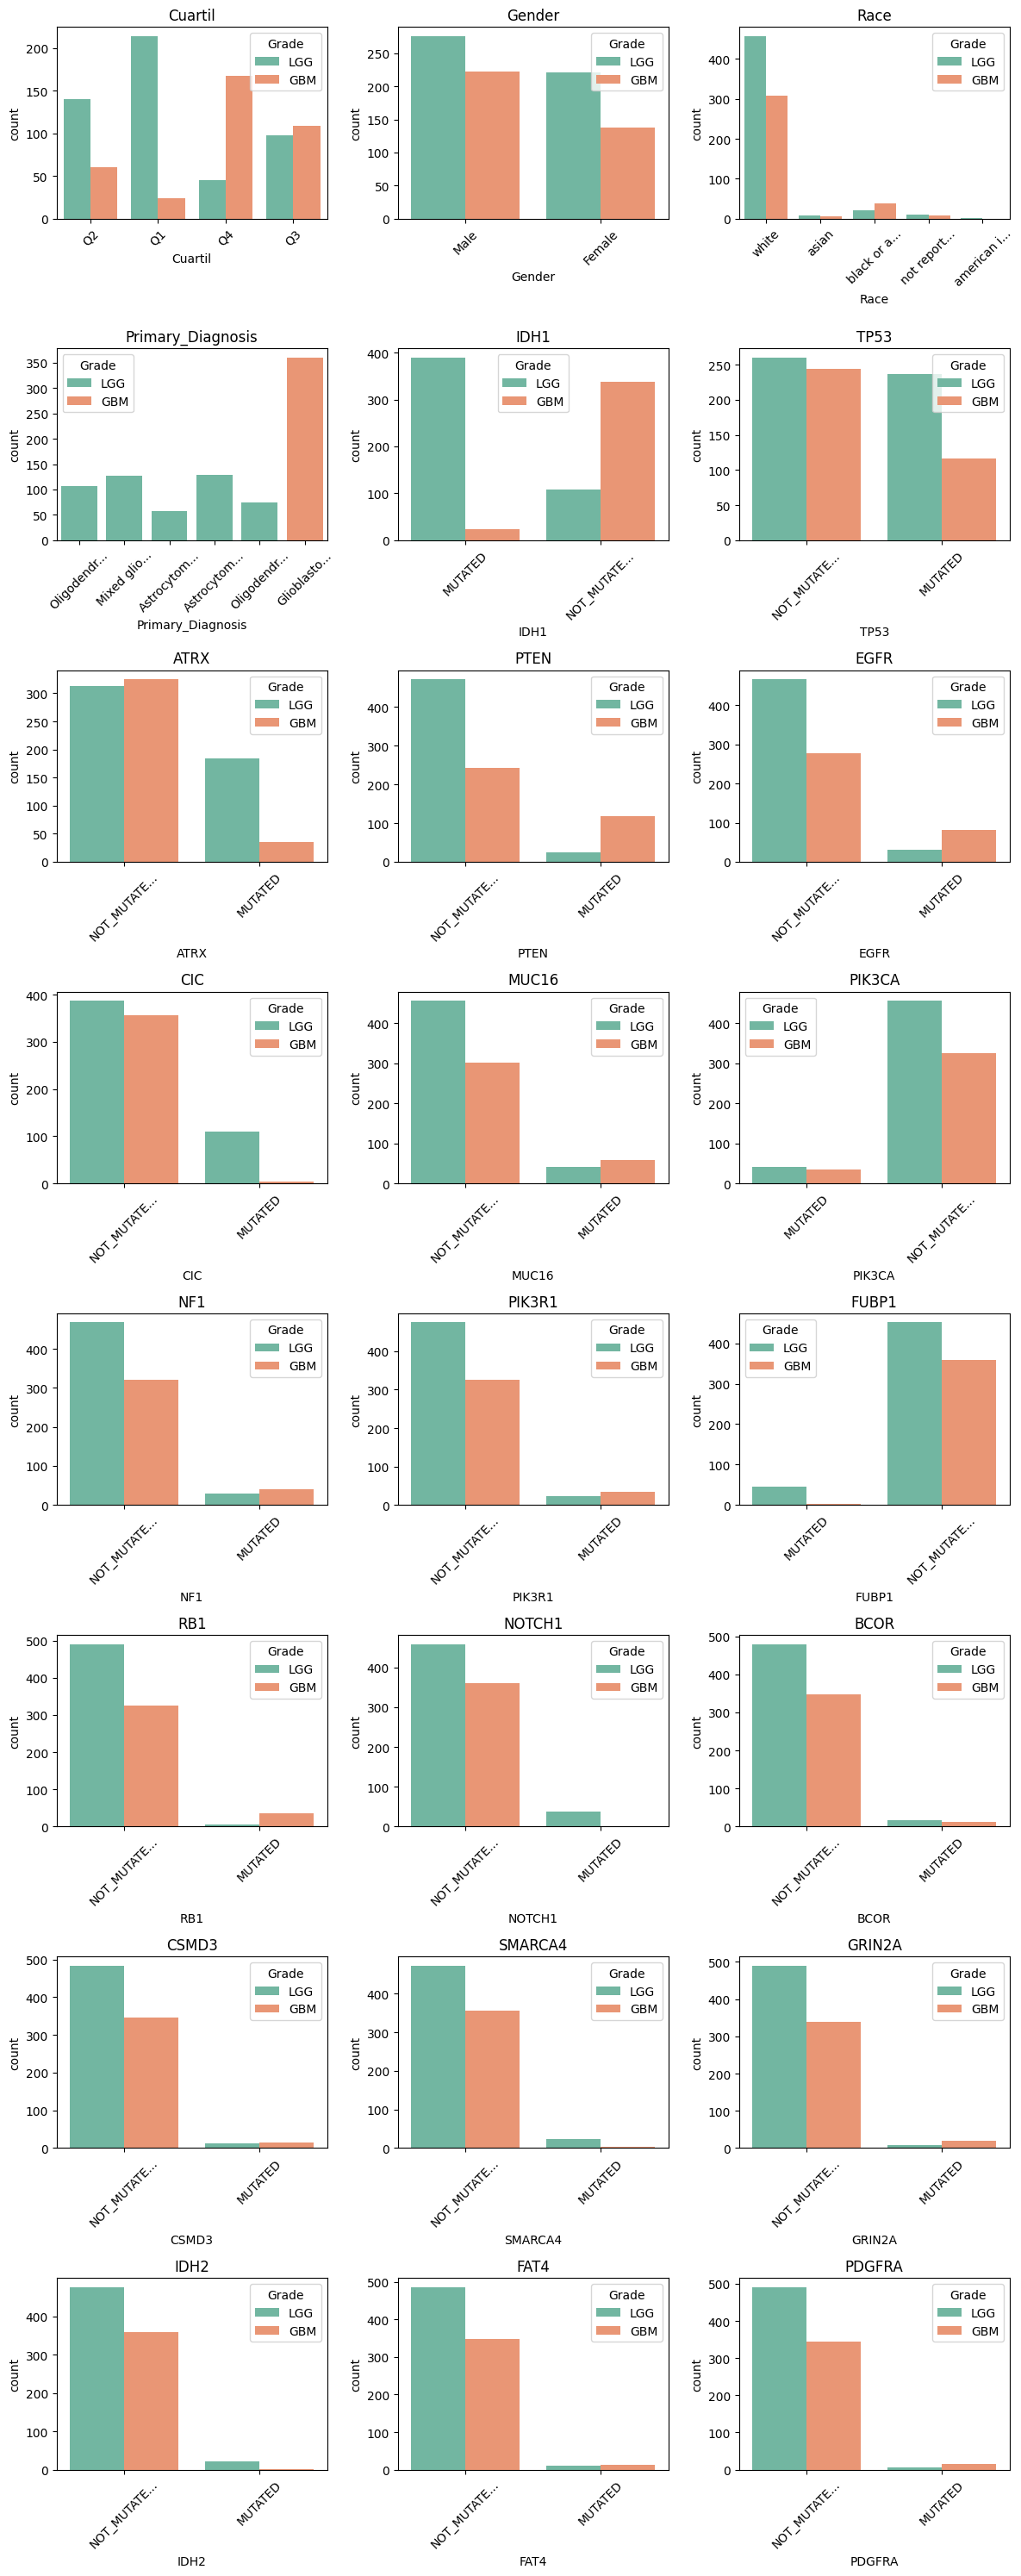

In [ ]:
# Obtener el índice de la columna 'IDH1'
nombre_columna = 'IDH1'
indice_columna = df.columns.get_loc(nombre_columna)

columnas_cat = df.columns[indice_columna:].tolist()
# Columnas útiles
columnas = ['Cuartil', 'Gender', 'Race', 'Primary_Diagnosis'] + columnas_cat
num_subplots = len(columnas)

# Calcular el número de filas y columnas necesarias para la cuadrícula
num_filas = (num_subplots + 2) // 3  # División entera para el número de filas
num_columnas = 3

# Cuadrícula de subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 30))

# Iterar sobre las columnas y crear un subplot para cada una
for i, col in enumerate(columnas):
    fila = i // 3
    columna = i % 3
    sns.countplot(data=df, x=col, hue='Grade', palette='Set2', ax=axs[fila, columna])
    axs[fila, columna].set_title(col)  # Establecer el título del subplot
    axs[fila, columna].set_xticklabels([label.get_text()[:10] + '...'
              if len(label.get_text()) > 10 else label.get_text() for label in
                                        axs[fila, columna].get_xticklabels()],
                                        rotation=45)

plt.tight_layout()
plt.show()

A primera vista, se observa que los atributos cuyos resultados muestran mayor desemejanza entre las clases objetivo incluyen, entre otros, la edad de los pacientes y el estado del gen IDH1. No obstante, se estudiará la inclusión de todos los diferentes atributos de estudio para garantizar la mayor precisión posible.

## Clasificadores

Antes de proceder con el proceso de clasificación, se comprobará la correlación entre los distintos atributos de estudio con el fin de simplificar la base de datos original. Para ello, se recurrirá al cálculo del coeficiente de Cramer como medida de cercanía entre las distintas variables.

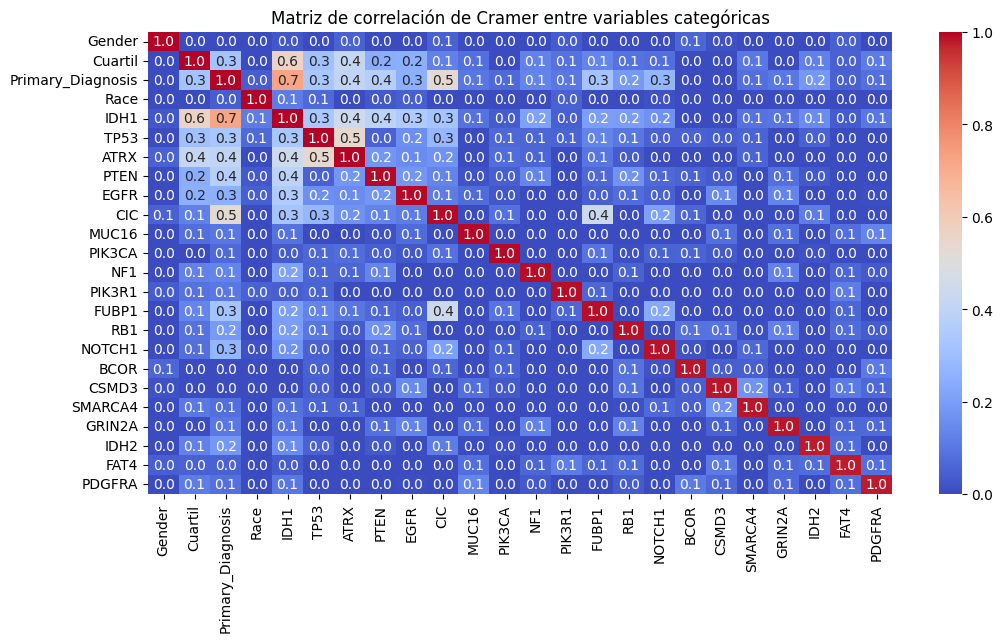

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Calcular la matriz de correlación
categorical_df = df[[df.columns[2]] + list(df.columns[6:])]
columns = categorical_df.columns
corr_matrix = pd.DataFrame(index=columns, columns=columns)

for i in range(len(columns)):
    for j in range(len(columns)):
        corr_matrix.iloc[i, j] = cramers_v(df[columns[i]], df[columns[j]])

# Convertir los valores de la matriz de correlación a tipo numérico
corr_matrix = corr_matrix.apply(pd.to_numeric)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Matriz de correlación de Cramer entre variables categóricas")
plt.show()

Observados los resultados, se concluye que no se puede eliminar ninguna de las variables, pues los coeficientes hallados entre columnas diferentes no presentan valores altos (mayores que 0.95).

A continuación, se realizará una última configuración del DataFrame con el fin de incluir en este la información estrictamente necesaria para su posterior clasificación. Para ello, obtenido el atributo asociado al cuartil de edad de cada paciente, se eliminarán la columna inicial que incluía la edad de diagnóstico en datos de tipo ```str```, así como las columnas que se obtuvieron a partir de esta información ('Years', 'Days'). Además, no se trabajará sobre la información de diagnosis, pues cada uno de los posibles diagnósticos está asociado a un solo tipo de glioma. Es decir, conocer el diagnóstico implica conocer el grado del glioma.

In [ ]:
# Convertir variables categóricas a numéricas

df_encoded = df.copy()
df_encoded = df_encoded.drop(['Age_at_diagnosis', 'Years', 'Days', 'Primary_Diagnosis'], axis=1)

columnas = ['Cuartil', 'Gender', 'Race'] + columnas_cat
df_encoded = pd.get_dummies(df_encoded, columns=columnas)
print(df_encoded.head())

  Grade       Case_ID  Cuartil_Q1  Cuartil_Q2  Cuartil_Q3  Cuartil_Q4  \
0   LGG  TCGA-DU-8164       False        True       False       False   
1   LGG  TCGA-QH-A6CY        True       False       False       False   
2   LGG  TCGA-HW-A5KM        True       False       False       False   
3   LGG  TCGA-E1-A7YE        True       False       False       False   
4   LGG  TCGA-S9-A6WG        True       False       False       False   

   Gender_Female  Gender_Male  Race_american indian or alaska native  \
0          False         True                                  False   
1          False         True                                  False   
2          False         True                                  False   
3           True        False                                  False   
4          False         True                                  False   

   Race_asian  ...  SMARCA4_MUTATED  SMARCA4_NOT_MUTATED  GRIN2A_MUTATED  \
0       False  ...            False                 

La función ```get_dummies``` ha generado columnas para cada uno de los valores de las diferentes características categóricas clasificadoras. Se conoce que todos los atributos sobre la información genética se dividen en MUTATED o NOT_MUTATED, y cada columna contiene ahora valores booleanos. Por lo tanto, la información explicada en cada columna MUTATED aporta, indirectamente, la información de la columna NOT_MUTATED. Luego se eliminarán estas últimas, pues se da redundancia.

In [ ]:
# Filtras las columnas que contienen "NOT_MUTATED" en su nombre
columnas_not_mutated = df_encoded.filter(regex='NOT_MUTATED')

# Muestra las columnas seleccionadas
df_encoded = df_encoded.drop(columns=columnas_not_mutated)
print(df_encoded)

    Grade       Case_ID  Cuartil_Q1  Cuartil_Q2  Cuartil_Q3  Cuartil_Q4  \
0     LGG  TCGA-DU-8164       False        True       False       False   
1     LGG  TCGA-QH-A6CY        True       False       False       False   
2     LGG  TCGA-HW-A5KM        True       False       False       False   
3     LGG  TCGA-E1-A7YE        True       False       False       False   
4     LGG  TCGA-S9-A6WG        True       False       False       False   
..    ...           ...         ...         ...         ...         ...   
857   GBM  TCGA-19-5959       False       False       False        True   
858   GBM  TCGA-16-0846       False       False       False        True   
859   GBM  TCGA-28-1746       False       False       False        True   
860   GBM  TCGA-32-2491       False       False       False        True   
861   GBM  TCGA-06-2557       False       False       False        True   

     Gender_Female  Gender_Male  Race_american indian or alaska native  \
0            False       

Se conocía que la tabla de datos presentaba a todos los pacientes de la clase LGG al comienzo, seguidos de los pacientes con glioma de tipo GBM. Se reordenan aleatoriamente los registros de la tabla de datos para asegurar que los distintos conjuntos sobre los que se estudien los clasificadores contengan pacientes pertenecientes a ambas clases objetivo.

In [ ]:
# Random_state para reproducibilidad
df_random = df_encoded.sample(frac=1, random_state=42)
print(df_random)

    Grade       Case_ID  Cuartil_Q1  Cuartil_Q2  Cuartil_Q3  Cuartil_Q4  \
716   GBM  TCGA-4W-AA9R       False       False        True       False   
605   GBM  TCGA-06-0190       False       False        True       False   
121   LGG  TCGA-DU-6394       False       False        True       False   
209   LGG  TCGA-DU-6395        True       False       False       False   
381   LGG  TCGA-FG-A70Y        True       False       False       False   
..    ...           ...         ...         ...         ...         ...   
72    LGG  TCGA-S9-A6U2       False        True       False       False   
107   LGG  TCGA-TQ-A7RO        True       False       False       False   
271   LGG  TCGA-DU-7309       False        True       False       False   
436   LGG  TCGA-DU-6396        True       False       False       False   
103   LGG  TCGA-P5-A5EU        True       False       False       False   

     Gender_Female  Gender_Male  Race_american indian or alaska native  \
716          False       

Por último, se tomarán las 10 últimas filas del DataFrame con conjunto de test sobre el cual el clasificador final hallado será evaluado.

In [ ]:
# Extraer las últimas diez filas
conjunto_test = df_random.iloc[-10:]
# Se eliminan del original
df_random = df_random.iloc[:-10]

In [ ]:
# Filtrar las filas por clase objetivo
lgg_count = conjunto_test[conjunto_test['Grade'] == 'LGG'].shape[0]
gbm_count = conjunto_test[conjunto_test['Grade'] == 'GBM'].shape[0]

print("Cantidad de 'lgg' en las últimas diez filas:", lgg_count)
print("Cantidad de 'gbm' en las últimas diez filas:", gbm_count)

Cantidad de 'lgg' en las últimas diez filas: 8
Cantidad de 'gbm' en las últimas diez filas: 2


Para nuestro cometido, se identificará como variable de clase u objetivo la predicción del grado de agresividad del glioma. Por lo tanto, el resto de columnas servirán para la explicación de este.

**Clase objetivo**

* **LGG**: Low Grade Glioma
* **GBM**: Glioblastoma Multiforme

Para la tarea de clasificación que se presenta, se comenzará evaluando la calidad de la información que el análisis del estudio genético de cada paciente aporta exclusivamente. De esta forma, se evaluarán los resultados que una serie de clasificadores de distinta naturaleza tienen. Una vez se conozca cuál de las técnicas candidatas conlleva una mayor precisión en la clasificación sobre datos no vistos anteriormente, se procederá a examinar los efectos que tiene la inclusión de otros atributos como el sexo o la edad sobre los resultados de clasificación.

En el presente estudio, se dividirán los datos presentes en la base de datos en dos subconjuntos; un conjunto de entrenamiento y un conjunto de test. Asimismo, cabe recordar que la base de datos de trabajo presenta un registro de pacientes relativamente limitado, con tan sólo 857 perfiles válidos. Por ello, se recurrirá a la técnica de validación cruzada, dividiendo el conjunto de datos en 5 partes iguales. De esta forma, en cada iteración, se tomará una de estas partes con el 20% de los registros como conjunto de test, y la información restante configurará el conjunto de entrenamiento del clasificador.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
nombre_columna = 'IDH1_MUTATED'
indice_columna = df_random.columns.get_loc(nombre_columna)

col_interest = df_random.columns[indice_columna:].tolist()
X = df_random[col_interest]  # Características
y = df_random['Grade']  # Variable objetivo

### Árboles de decisión

#### Criterio de Gini

In [ ]:
# Crear clasificador
classifier = DecisionTreeClassifier(criterion='gini')

# Validación cruzada
cv_scores = cross_val_score(classifier, X, y, cv=5)
print(cv_scores)
print("Precisión media de validación cruzada:", np.mean(cv_scores))
print("Error medio de validación cruzada:", (1-np.mean(cv_scores)))

[0.85294118 0.84705882 0.80473373 0.87573964 0.84023669]
Precisión media de validación cruzada: 0.8441420118343196
Error medio de validación cruzada: 0.15585798816568042


#### Criterio de entropía

In [ ]:
# Crear clasificador
classifier = DecisionTreeClassifier(criterion='entropy')

# Validación cruzada
cv_scores = cross_val_score(classifier, X, y, cv=5)
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media de validación cruzada:", np.mean(cv_scores))
print("Error medio de validación cruzada:", (1-np.mean(cv_scores)))

Puntuaciones de validación cruzada: [0.85294118 0.84705882 0.81656805 0.87573964 0.84615385]
Precisión media de validación cruzada: 0.8476923076923077
Error medio de validación cruzada: 0.15230769230769226


### KNN

In [ ]:
# Crear clasificador KNN
knn_classifier = KNeighborsClassifier()

# Realizar validación cruzada
cv_scores = cross_val_score(knn_classifier, X, y, cv=5)

print(cv_scores)
print("Media de las puntuaciones de validación cruzada para el clasificador KNN:", np.mean(cv_scores))
print("Error medio de validación cruzada:", (1-np.mean(cv_scores)))

[0.87058824 0.85294118 0.81656805 0.84615385 0.85798817]
Media de las puntuaciones de validación cruzada para el clasificador KNN: 0.8488478941872607
Error medio de validación cruzada: 0.1511521058127393


### Teorema de Bayes

In [ ]:
# Crear y entrenar el clasificador Naive Bayes
nb_classifier = GaussianNB()
# Realizar validación cruzada
cv_scores = cross_val_score(nb_classifier, X, y, cv=5)

print(cv_scores)
print("Media de las puntuaciones de validación cruzada para el clasificador Naive Bayes:", np.mean(cv_scores))
print("Error medio de validación cruzada:", (1-np.mean(cv_scores)))

[0.57647059 0.72941176 0.69822485 0.79881657 0.75739645]
Media de las puntuaciones de validación cruzada para el clasificador Naive Bayes: 0.7120640445527322
Error medio de validación cruzada: 0.2879359554472678


### Support vector machines

In [ ]:
# Crear modelo SVC
model_svc = SVC(kernel='linear')

# Crear objeto KFold para validación cruzada
cv = KFold(n_splits=5, shuffle=False)

# Realizar validación cruzada
cv_scores = cross_val_score(model_svc, X, y, cv=cv)

# Imprimir la media de las puntuaciones de validación cruzada
print(cv_scores)
print("Media de las puntuaciones de validación cruzada para el modelo SVC:", np.mean(cv_scores))
print("Error medio de validación cruzada:", (1-np.mean(cv_scores)))

[0.89411765 0.85294118 0.82248521 0.89349112 0.89349112]
Media de las puntuaciones de validación cruzada para el modelo SVC: 0.8713052558301427
Error medio de validación cruzada: 0.12869474416985727


A partir de los resultados obtenidos para cada una de las alternativas del tipo de clasificador, se observa que la clasificación con Support Vector Machines muestra un mayor nivel de precisión. Como se ha mencionado previamente, esta tarea de clasificación se ha llevado a cabo con la información genética como únicos atributos clasificadores. A continuación, se estudiará como incluir distintos atributos al clasificador afecta a la precisión. Para ello, se comenzará estudiando si existen mejoras al introducir la información sobre la edad.

In [ ]:
media_def = np.mean(cv_scores)

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Con la edad
X = df_random[df_random.columns[2:6].tolist() + col_interest]  # Características
y = df_random['Grade']  # Variable objetivo

In [ ]:
# Crear modelo SVC
model_svc = SVC(kernel='linear')

# Crear objeto KFold para validación cruzada
cv = KFold(n_splits=5, shuffle=False)

# Realizar validación cruzada
cv_scores = cross_val_score(model_svc, X, y, cv=cv)

# Imprimir la media de las puntuaciones de validación cruzada
print("Media de las puntuaciones para el modelo SVC con la edad:", np.mean(cv_scores))
print("Mejora frente al modelo original:", np.mean(cv_scores) - media_def)

Media de las puntuaciones para el modelo SVC con la edad: 0.8713052558301427
Mejora frente al modelo original: 0.0


No se obtienen mejoras en la precisión. Se continúa estudiando el impacto de la incorporación del sexo del paciente a la información genética.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Con el sexo
X = df_random[df_random.columns[6:8].tolist() + col_interest]  # Características
y = df_random['Grade']  # Variable objetivo

In [ ]:
# Crear modelo SVC
model_svc = SVC(kernel='linear')

# Crear objeto KFold para validación cruzada
cv = KFold(n_splits=5, shuffle=False)

# Realizar validación cruzada
cv_scores = cross_val_score(model_svc, X, y, cv=cv)

# Imprimir la media de las puntuaciones de validación cruzada
print("Media de las puntuaciones para el modelo SVC con el género:", np.mean(cv_scores))
print("Mejora frente al modelo original:", np.mean(cv_scores) - media_def)

Media de las puntuaciones para el modelo SVC con el género: 0.8701218238774799
Mejora frente al modelo original: -0.0011834319526627946


No sólo no se dan mejoras, sino que el clasificador disminuye su precisión. Por último, se analiza qué sucede al incorporar la etnia.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Con la etnia
X = df_random[df_random.columns[8:13].tolist() + col_interest]  # Características
y = df_random['Grade']  # Variable objetivo

In [ ]:
# Crear modelo SVC
model_svc = SVC(kernel='linear')

# Crear objeto KFold para validación cruzada
cv = KFold(n_splits=5, shuffle=False)

# Realizar validación cruzada
cv_scores = cross_val_score(model_svc, X, y, cv=cv)

# Imprimir la media de las puntuaciones de validación cruzada
print("Media de las puntuaciones para el modelo SVC con la etnia:", np.mean(cv_scores))
print("Mejora frente al modelo original:", np.mean(cv_scores) - media_def)

Media de las puntuaciones para el modelo SVC con la etnia: 0.8713052558301427
Mejora frente al modelo original: 0.0


De acuerdo con los resultados obtenidos, se comprueba que rasgos ajenos a parámetros médicos acerca de la enfermedad no influyen en la precisión del proceso. Por lo tanto, los resultados más favorables surgen a raíz de la información contenida en los tests genéticos. Aun así, recordando las previas representaciones gráficas, se va a comprobar la precisión que los grupos de edad muestran exclusivamente sobre la clasificación.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Con la edad
X = df_random[df_random.columns[2:6].tolist()]  # Características
y = df_random['Grade']  # Variable objetivo

In [ ]:
# Crear modelo SVC
model_svc = SVC(kernel='linear')

# Crear objeto KFold para validación cruzada
cv = KFold(n_splits=5, shuffle=False)

# Realizar validación cruzada
cv_scores = cross_val_score(model_svc, X, y, cv=cv)

# Imprimir la media de las puntuaciones de validación cruzada
print("Media de las puntuaciones para el modelo SVC con el género:", np.mean(cv_scores))

Media de las puntuaciones para el modelo SVC con el género: 0.718941872607031


Se comprueba que el nivel de precisión conseguido con los cuartiles se aproxima bastante a la precisión que se había conseguido con todos los genes. Por lo tanto, se va a comprobar si se puede prescindir de la información aportada por alguno de los genes. Para ello, se evaluará la precisión que cada uno de los genes tiene como clasificador de las clases objetivo. Así, se evaluará la incorporación de genes a los atributos clasificadores en orden descendente de precisión, es decir, les damos prioridad a los genes que más información aporten por sí solos.



In [ ]:
# La i contiene la cantidad de genes que conoce
i = 0
vector = []

while indice_columna+(i+1) <= df_random.shape[1]:
  i += 1

  # Dividir los datos en conjunto de entrenamiento y prueba
  # Con la edad
  X = df_random[df_random.columns[indice_columna+(i-1):indice_columna+i].tolist()]  # Características
  y = df_random['Grade']  # Variable objetivo

  # Crear modelo SVC
  model_svc = SVC(kernel='linear')

  # Crear objeto KFold para validación cruzada
  cv = KFold(n_splits=5, shuffle=False)

  # Realizar validación cruzada
  cv_scores = cross_val_score(model_svc, X, y, cv=cv)
  vector.append(np.mean(cv_scores))

print(vector)

[0.848868778280543, 0.5595335885833623, 0.5962269404803341, 0.6858684302123217, 0.6363104768534633, 0.577285067873303, 0.5973546815175774, 0.5678176122520014, 0.591409676296554, 0.5926348764357814, 0.577285067873303, 0.611521058127393, 0.577285067873303, 0.577285067873303, 0.577285067873303, 0.577285067873303, 0.5926279150713539, 0.577285067873303, 0.5725791855203619, 0.5890776192133658]


In [ ]:
indices_ordenados = np.argsort(vector)[::-1]
print("Lista de índices ordenados de mayor a menor:", indices_ordenados)

Lista de índices ordenados de mayor a menor: [ 0  3  4 11  6  2  9 16  8 19 12 13 10 14  5 15 17 18  7  1]


In [ ]:
# La i contiene la cantidad de genes que conoce
i = -1
indices = []
media_prov = 0

while media_def - media_prov > 0:

  i += 1
  indices.append(indice_columna + indices_ordenados[i])

  # Dividir los datos en conjunto de entrenamiento y prueba
  # Con la edad
  X = df_random[df_random.columns[2:6].tolist() + df_random.columns[indices].tolist()]  # Características
  y = df_random['Grade']  # Variable objetivo

  # Crear modelo SVC
  model_svc = SVC(kernel='linear')

  # Crear objeto KFold para validación cruzada
  cv = KFold(n_splits=5, shuffle=False)

  # Realizar validación cruzada
  cv_scores = cross_val_score(model_svc, X, y, cv=cv)
  media_prov = np.mean(cv_scores)

print(f'Se obtiene la mayor precisión posible con la edad y {i+1} de los {df_random.shape[1]-(indice_columna)} genes')

Se obtiene la mayor precisión posible con la edad y 17 de los 20 genes


### Clasificador final

Una vez se han decidido los atributos adecuados para clasificar los pacientes de la presente base de datos, se comprueba por última vez su precisión.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y prueba
indices = []

for i in range(0, 17):
  indices.append(indice_columna + indices_ordenados[i])

X = df_random[df_random.columns[2:6].tolist() +  df_random.columns[indices].tolist()]  # Características
y = df_random['Grade']  # Variable objetivo

In [ ]:
# Crear modelo SVC
model_svc = SVC(kernel='linear')

# Crear objeto KFold para validación cruzada
cv = KFold(n_splits=5, shuffle=False)

# Realizar validación cruzada
cv_scores = cross_val_score(model_svc, X, y, cv=cv)

# Imprimir la media de las puntuaciones de validación cruzada
print("Media de las puntuaciones para el modelo SVC con el género:", np.mean(cv_scores))
print("Error medio de validación cruzada:", (1-np.mean(cv_scores)))

Media de las puntuaciones para el modelo SVC con el género: 0.8713052558301427
Error medio de validación cruzada: 0.12869474416985727


Por último, se analizará la eficiencia del clasificador en la tarea de asignación de clases sobre los 10 clientes que se habían apartado previamente. En este caso, el clasificador se entrenará ya con todos los datos de train de una sola vez.

In [ ]:
X_test = conjunto_test[conjunto_test.columns[2:6].tolist() +  conjunto_test.columns[indices].tolist()]
y_test = conjunto_test['Grade']  # Variable objetivo

In [ ]:
# Entrenamiento
model_svc = SVC(kernel='linear')
model_svc.fit(X, y)

# Predecir las etiquetas del conjunto de datos de prueba
y_pred = model_svc.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo en el conjunto de prueba:", accuracy)
print("Error del modelo en el conjunto de prueba:", (1-accuracy))

Precisión del modelo en el conjunto de prueba: 0.9
Error del modelo en el conjunto de prueba: 0.09999999999999998


Se ha obtenido una precisión del 90% sobre el conjunto de test, mayor a los resultados que se obtenían en la validación del modelo clasificador. Por lo tanto, se puede concluir que la elección ha sido acertada.

No obstante, resulta importante plantear si los valores métricos obtenidos resultan suficientes para el tema de estudio. La clasificación de la gravedad de los gliomas cancerígenos es un aspecto clave que define el tratamiento y pronóstico del paciente. Asimismo, contando con el aspecto crítico que implica el tratamiento de una enfermedad como el cáncer, errores en la clasificación del glioma pueden implicar consecuencias bastante graves, como el retraso o la falta de adecuación del tratamiento elegido. Por lo tanto, bien si una precisión del 90% es un valor relativamente alto, la colaboración con profesionales de este campo sería clave para la evaluación correcta de la viabilidad del clasificador.

## Práctica 3 (Detección de Malware)

En la Universidad Francisco de Vitoria se quieren trazas de comunicación de la red para encontrar distintos malwares. Dicho clasificador funcionará mediante un set de entrenamiento donde se buscará un plano que divida las diferentes clases dispuesta en un espacio n-dimensional dependiendo de sus características.
Para ello usaremos el dataset “Malware”. Elige el clasificador que más se adapte de entre los vistos en clase y usa scikit-learn junto con las librerías que necesites para resolver las siguientes cuestiones.

1) Crea un clasificador, realiza al menos tres configuraciones y dibuja una tabla donde se muestre la precisión con la que clasifican. ¿Cómo funcionaría si no usamos kernels? ¿Y al usar distintos kernels?

Para facilitar el acceso al archivo ZIP donde están contenidos los datos y que estos se carguen más rapidamente, se subirá el archivo a Google Drive y luego se facilitará el acceso a dicho archivo desde el entorno de Google Colab.

En primer lugar, se monta Google Drive en el entorno de Colab, lo que permite acceder a los archivos almacenados en Google Drive desde el entorno de Colab. Luego, se especifica la ruta al archivo ZIP deseado en Google Drive y la ruta donde se descomprimirán los archivos del ZIP en el entorno de Colab.

Utilizando la biblioteca `zipfile` de Python, se abre el archivo ZIP especificado en modo de lectura y se extraen todos los archivos contenidos en él.

Finalmente, se obtiene una lista de los nombres de archivo de los archivos extraídos en el directorio de destino y se imprime esta lista para verificar que la extracción se realizó correctamente.

In [ ]:
# Montar Google Drive en Google Colab
drive.mount('/content/drive')

# Ruta al archivo Malware.zip en tu Google Drive
file_path = '/content/drive/My Drive/Malware.zip'

# Ruta donde se extraerán los archivos del zip
extract_path = '/content/Malware_dataset'

# Descomprimir el archivo Malware.zip
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Ahora puedes trabajar con los archivos extraídos en extract_path
extracted_files = os.listdir(extract_path)
print("Archivos extraídos:", extracted_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos extraídos: ['Malware']


Dentro del archivo ZIP llamado Malware, se encuentran cuatro carpetas, cada una con un nombre que corresponde a una etiqueta específica. Estas etiquetas representan las siguientes clases de malware:

1. **Agent.FYI**
2. **Fakerean**
3. **Lolyda.AA1**
4. **Yuner.A**

Para empezar a procesar los datos se definen dos listas vacías: una para almacenar los datos y otra para almacenar las etiquetas asociadas a esos datos.
Luego se especifica la ruta al directorio donde se encuentran las carpetas de malware dentro del archivo ZIP descomprimido en el entorno de Colab, y se itera sobre cada carpeta de malware, recorriendo los archivos dentro de ella.

Para cada archivo, se lee su contenido como binario y se agrega a la lista de datos. Además, se agrega la etiqueta correspondiente (el nombre de la carpeta de malware) a la lista de etiquetas.

Después de recopilar todos los datos y las etiquetas, se convierten las etiquetas de texto a números enteros. Esto se hace mediante la creación de un mapa que asigna cada etiqueta a un número entero único, y luego se utiliza este mapa para convertir las etiquetas de texto en números.

Finalmente, se vectorizan los datos utilizando la técnica TF-IDF.

**Técnica TF-IDF**

El `TfidfVectorizer` es una herramienta fundamental en el procesamiento de texto en el aprendizaje automático. Tfidf significa "Term Frequency-Inverse Document Frequency", que es una medida de la importancia de una palabra en un documento en relación con un conjunto de documentos. Básicamente, TfidfVectorizer convierte una colección de documentos de texto en una matriz de características TF-IDF, donde cada fila representa un documento y cada columna representa una palabra o término, y los valores son las puntuaciones TF-IDF de cada término en cada documento.

1. **TF (Term Frequency - Frecuencia del término)**: Mide la frecuencia con la que aparece un término (una palabra en este caso) en un documento. Cuantas más veces aparezca un término en un documento, mayor será su importancia relativa para ese documento. La fórmula para calcular TF es:

   $$ \text{TF}(t, d) = \frac{\text{Número de veces que el término } t \text{ aparece en el documento } d}{\text{Número total de términos en el documento } d} $$

2. **IDF (Inverse Document Frequency - Frecuencia inversa del documento)**: Mide la rareza de un término en toda la colección de documentos. Si un término es muy común en todos los documentos, su IDF será bajo. Si el término es poco común y aparece solo en unos pocos documentos, su IDF será alto. La fórmula para calcular IDF es:

   $$ \text{IDF}(t, D) = \log{\left(\frac{\text{Número total de documentos en la colección } D}{\text{Número de documentos que contienen el término } t}\right)} $$

3. **TF-IDF (Term Frequency-Inverse Document Frequency)**: Combina las dos medidas anteriores para calcular un peso para cada término en cada documento de una colección de documentos. El TF-IDF se calcula multiplicando la frecuencia del término (TF) por la frecuencia inversa del documento (IDF). Esto da más peso a los términos que son frecuentes en un documento específico pero raros en el conjunto de documentos. La fórmula para calcular TF-IDF es:

   $$ \text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D) $$

En resumen, la técnica TF-IDF es útil para determinar la importancia de una palabra en un documento en relación con su aparición en una colección de documentos más grande. Se utiliza en tareas como recuperación de información, clasificación de documentos y análisis de texto para identificar palabras clave y características importantes.

Esto es importante porque muchos algoritmos de aprendizaje automático, incluidos los utilizados en la clasificación de textos, como el SVM (Support Vector Machine) en este caso, requieren que los datos de entrada estén en forma numérica. Vectorizar los datos de texto es esencial para representar los documentos de texto de manera que puedan ser procesados por estos algoritmos.

En cuanto al parámetro `encoding='latin1'`, se utiliza para especificar cómo deben decodificarse los datos de entrada que están en formato binario. 'latin1' es un tipo de codificación de caracteres que es capaz de representar todos los bytes posibles (256 caracteres) y se utiliza comúnmente cuando se trabaja con datos de texto en inglés y otros idiomas europeos.

En este caso particular, se usa 'latin1' como un valor predeterminado seguro cuando se lee el contenido de archivos binarios que pueden contener texto. Esto asegura que los caracteres especiales y los bytes de datos se decodifiquen correctamente sin pérdida de información.

In [ ]:
# Listas para almacenar los datos y las etiquetas
data = []
labels = []

# Ruta al directorio donde se encuentran las carpetas de malware
data_dir = os.path.join(extract_path, 'Malware')

# Recorre las carpetas de malware
class_names = sorted(os.listdir(data_dir))
for malware_class in class_names:
    malware_class_dir = os.path.join(data_dir, malware_class)
    if os.path.isdir(malware_class_dir):
        # Lee los archivos dentro de cada clase
        for file_name in os.listdir(malware_class_dir):
            file_path = os.path.join(malware_class_dir, file_name)
            with open(file_path, 'rb') as file:
                # Lee el contenido del archivo como binario
                content = file.read()
                data.append(content)
                labels.append(malware_class)

# Convertir las etiquetas de texto a números
label_map = {label: index for index, label in enumerate(class_names)}
labels = [label_map[label] for label in labels]

# Vectorización de los datos
vectorizer = TfidfVectorizer(input='content', encoding='latin1')
X = vectorizer.fit_transform(data)
y = np.array(labels)

Se va a calcular la distribución de las clases en el conjunto de datos, es decir, cuenta cuántas instancias hay para cada clase.

Es importante verificar si las clases están balanceadas antes de aplicar SVM (Support Vector Machine) u otros algoritmos de aprendizaje automático porque el desequilibrio en las clases puede afectar significativamente el rendimiento del modelo. Cuando las clases están desbalanceadas, significa que hay muchas más instancias de una clase que de otras. Esto puede llevar a que el modelo aprenda a predecir predominantemente la clase mayoritaria, ignorando las clases minoritarias.

Las razones por las que es importante tener clases balanceadas son varias:

1. **Bias en la predicción**: Los modelos entrenados en conjuntos de datos desbalanceados tienden a tener un sesgo hacia la clase mayoritaria, ya que esto maximiza la precisión general.

2. **Rendimiento incorrecto del modelo**: La métrica de rendimiento puede ser engañosa si el modelo está sesgado hacia la clase mayoritaria. Por ejemplo, la precisión puede ser alta simplemente prediciendo siempre la clase mayoritaria, pero esto no significa que el modelo esté aprendiendo patrones útiles.

3. **Sensibilidad a la clase minoritaria**: Las clases minoritarias pueden contener información importante pero pueden ser pasadas por alto si el modelo no está equilibrado.

4. **Costos asimétricos de errores**: En muchos casos, los errores en la clasificación de la clase minoritaria pueden ser más costosos que los errores en la clasificación de la clase mayoritaria.

Por lo tanto, verificar y corregir el desequilibrio de clases es crucial para desarrollar modelos de aprendizaje automático efectivos y equitativos.
Este código ayuda a identificar si existe desbalance de clases en los datos, lo que puede ser útil para aplicar técnicas de remuestreo o ponderación de clases para abordar este problema antes de entrenar el modelo de SVM.

In [ ]:
# Verificar si las clases están desbalanceadas
class_distribution = {class_name: labels.count(label_map[class_name]) for class_name in class_names}
print("Distribución de clases:", class_distribution)

Distribución de clases: {'Agent.FYI': 66, 'Fakerean': 59, 'Lolyda.AA1': 167, 'Yuner.A': 173}


Como podemos ver, las clases no están equilibradas, por lo que se va a aplicar una técnica llamada "sobremuestreo aleatorio" (Random OverSampling) a los datos de entrada X y las etiquetas correspondientes y.

El sobremuestreo aleatorio es una técnica utilizada para abordar el problema de desequilibrio de clases en conjuntos de datos. Consiste en generar nuevas instancias de la clase minoritaria (aquella que tiene menos muestras) mediante la duplicación aleatoria de las instancias existentes en esa clase. Esto se hace hasta que todas las clases tengan aproximadamente el mismo número de instancias.


In [ ]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

Vamos a calcular el número de características que tiene el conjunto de datos. Para ello se utiliza la propiedad `shape[1]` de la matriz `X_resampled`, que representa el número de columnas en la matriz de características.

Como hay 360022 características, se va a hacer una selección de características por importancia de frecuencia. Se crea una instancia del objeto `SelectKBest` que utiliza la función de puntuación chi-cuadrado (`chi2`) para evaluar la importancia de las características. Después de probar múltiples valores, se especifica que se seleccionarán las 600 características más importantes utilizando el parámetro `k=600`, puesto que con este número se obtenían los mejores resultados de precisión en los modelos.


Es importante reducir características en un conjunto de datos por varias razones:

1. **Reducción de la dimensionalidad**: Los conjuntos de datos con un gran número de características pueden llevar a problemas de dimensionalidad, lo que puede afectar negativamente el rendimiento de los modelos de aprendizaje automático y aumentar la complejidad computacional.

2. **Eliminación de características irrelevantes o redundantes**: No todas las características pueden ser relevantes para la tarea de predicción. La eliminación de características irrelevantes o redundantes puede mejorar la precisión del modelo y facilitar la interpretación de los resultados.

3. **Reducción del sobreajuste**: Un gran número de características puede aumentar el riesgo de sobreajuste (overfitting), especialmente en conjuntos de datos pequeños. Al reducir el número de características, se puede reducir la complejidad del modelo y mejorar su capacidad para generalizar a nuevos datos.


In [ ]:
# Calcular el número de características antes de la selección
num_features_before_selection = X_resampled.shape[1]
print("Número de características antes de la selección:", num_features_before_selection)

# Selección de características por importancia de la frecuencia
selector = SelectKBest(chi2, k=600)  # Selecciona las 600 características más importantes
X_selected = selector.fit_transform(X_resampled, y_resampled)

Número de características antes de la selección: 360022


Se van a dividir los datos en tres conjuntos distintos: un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba.

1. **División inicial en conjunto de entrenamiento y conjunto temporal**: Se utiliza la función `train_test_split` para dividir el conjunto de datos en dos partes: un conjunto de entrenamiento y un conjunto temporal. Se especifica que el 30% de los datos se reservarán para el conjunto temporal, mientras que el 70% se utilizará para el conjunto de entrenamiento. Los datos se dividen de forma aleatoria, pero se establece una semilla aleatoria (`random_state=42`) para garantizar la reproducibilidad de la división.

2. **División del conjunto temporal en conjunto de validación y conjunto de prueba**: El conjunto temporal se divide nuevamente en dos partes iguales: un conjunto de validación y un conjunto de prueba. Se utiliza la misma función `train_test_split` con un tamaño de prueba del 50%. Esto significa que el 25% de los datos originales se asignarán al conjunto de validación y el 25% al conjunto de prueba. Al igual que en la división inicial, se establece una semilla aleatoria para garantizar la reproducibilidad.

Es importante dividir los datos en tres conjuntos por las siguientes razones:

1. **Entrenamiento del modelo**: El conjunto de entrenamiento se utiliza para ajustar los parámetros del modelo y aprender patrones a partir de los datos.

2. **Validación del modelo**: El conjunto de validación se utiliza para ajustar los hiperparámetros del modelo y evaluar su rendimiento durante el proceso de entrenamiento. Esto ayuda a seleccionar el mejor modelo y evitar el sobreajuste.

3. **Evaluación final del modelo**: El conjunto de prueba se utiliza para evaluar el rendimiento final del modelo seleccionado. Proporciona una estimación imparcial de cómo el modelo generaliza a datos no vistos.

Dividir los datos en tres conjuntos permite evaluar el rendimiento del modelo de manera más precisa y tomar decisiones informadas sobre su capacidad para generalizar a nuevos datos. Además, al establecer una semilla aleatoria, garantizamos que la división de los datos sea consistente y reproducible en diferentes ejecuciones del código.

In [ ]:
# División de los datos en conjunto de entrenamiento, validación y conjunto de prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Se va a utilizar Support Vector Machine como clasificador por varias razones:

1. **Eficacia en la clasificación de imágenes**: SVM ha demostrado ser efectivo en la clasificación de imágenes en una variedad de aplicaciones, incluidas la detección de objetos, reconocimiento facial, y clasificación de imágenes en general. Su capacidad para construir hiperplanos de separación óptimos entre clases lo hace adecuado para tareas de clasificación visual como esta.

2. **Manejo de características de alta dimensión**: SVM puede manejar eficientemente conjuntos de datos con un gran número de características, como los extraídos de imágenes. Esto es importante en el procesamiento de imágenes, donde cada píxel puede considerarse una característica, lo que resulta en espacios de características de alta dimensión.

3. **Robustez frente a sobreajuste**: SVM es conocido por su capacidad para generalizar bien en conjuntos de datos de imágenes, lo que significa que puede evitar el sobreajuste incluso en conjuntos de datos complejos. Esto es crucial en la clasificación de imágenes, donde se pueden encontrar variaciones significativas en la apariencia de objetos dentro de una misma clase.

4. **Flexibilidad en la elección del kernel**: SVM permite la especificación de diferentes funciones de kernel, como lineal, polinomial y radial (RBF), lo que brinda flexibilidad para adaptarse a diferentes estructuras y distribuciones de datos. Esto es útil en la clasificación de imágenes, donde las relaciones entre características pueden ser no lineales y pueden beneficiarse de kernels más complejos.


A continuación se realiza una búsqueda exhaustiva de los mejores hiperparámetros para el modelo de Support Vector Machine (SVM) utilizando la técnica de validación cruzada en cuadrícula (GridSearchCV).

Primero, se define un diccionario `param_grid` que contiene los diferentes parámetros y sus respectivos valores que se probarán para el modelo de SVM. Entre estos parámetros se encuentra `gamma`, el cual controla el ancho del kernel de RBF (Radial Basis Function) en el caso de que se utilice este kernel. La variación de `gamma` permite evaluar diferentes grados de complejidad y flexibilidad en la forma de la frontera de decisión del modelo.

Además, dentro de `param_grid`, se encuentra el parámetro `C`, que controla la regularización del modelo. `C` indica el margen de tolerancia de error del modelo. Valores más altos de `C` implican un margen de tolerancia menor, lo que puede llevar a un modelo más ajustado a los datos de entrenamiento pero posiblemente con mayor riesgo de sobreajuste. Por otro lado, valores más bajos de `C` permiten un margen de tolerancia mayor, lo que puede llevar a un modelo más generalizado.

El GridSearchCV realiza esta búsqueda exhaustiva de combinaciones de hiperparámetros y selecciona la combinación que produce el mejor rendimiento promedio en todos los pliegues de la validación cruzada.

Finalmente, el método `fit()` ajusta el modelo a los datos de entrenamiento, explorando todas las combinaciones posibles de hiperparámetros y evaluando el rendimiento del modelo utilizando la validación cruzada. Al finalizar, el objeto `grid_search` contiene información sobre la mejor combinación de hiperparámetros encontrada durante la búsqueda.

In [ ]:
# Definir los parámetros a probar para el GridSearchCV
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Realizar búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

Los resultados de la búsqueda de hiperparámetros realizada anteriormente utilizando GridSearchCV se muestran en forma de tabla.

Primero, se importa la biblioteca pandas como pd para facilitar el manejo y análisis de datos en forma de tablas.

Luego, se crea un DataFrame llamado `results_df` a partir de los resultados de la búsqueda de hiperparámetros (`grid_search.cv_results_`). Se seleccionan algunas columnas específicas de interés del DataFrame original, incluyendo los parámetros de kernel, C y gamma que se probaron, así como el puntaje medio de prueba (`mean_test_score`) que representa la precisión promedio del modelo en la validación cruzada.

Finalmente, se imprime la tabla de resultados para visualizar los parámetros probados junto con sus respectivos puntajes de precisión promedio en la validación cruzada. Esto proporciona una visión general de cómo diferentes combinaciones de parámetros afectan el rendimiento del modelo, lo que puede ser útil para seleccionar la mejor configuración de hiperparámetros para el problema dado.

In [ ]:
# Obtener los resultados de la búsqueda
import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)[['param_kernel', 'param_C', 'param_gamma', 'mean_test_score']]

# Muestra la tabla de resultados
print("\nTabla de resultados:")
print(results_df)


Tabla de resultados:
   param_kernel param_C param_gamma  mean_test_score
0        linear     0.1       0.001         0.512393
1           rbf     0.1       0.001         0.260331
2          poly     0.1       0.001         0.260331
3        linear     0.1        0.01         0.512393
4           rbf     0.1        0.01         0.260331
5          poly     0.1        0.01         0.260331
6        linear     0.1         0.1         0.512393
7           rbf     0.1         0.1         0.260331
8          poly     0.1         0.1         0.260331
9        linear     0.1           1         0.512393
10          rbf     0.1           1         0.512393
11         poly     0.1           1         0.260331
12       linear     0.1          10         0.512393
13          rbf     0.1          10         0.512393
14         poly     0.1          10         0.512393
15       linear       1       0.001         0.512393
16          rbf       1       0.001         0.260331
17         poly       1 

**¿Cómo funcionaría si no usamos kernels?:**

Si no utilizamos kernels en un clasificador SVM, estaríamos utilizando lo que se conoce como un SVM lineal. En este caso, el SVM se limitaría a realizar clasificaciones lineales en el espacio original de características.

**¿Y al usar distintos kernels?:**

Al utilizar distintos kernels como 'rbf' (Radial Basis Function) y 'poly' (Polinomial), el modelo tiene la capacidad de realizar clasificaciones no lineales en espacios de características de mayor dimensión.
Para comparar los tres tipos de kernels utilizados (lineal, RBF y polinómico), observamos las siguientes tendencias en la tabla de resultados:

1. **Precisión general (mean_test_score)**:
   - El kernel RBF parece tener la precisión más baja en la mayoría de los casos, especialmente para valores bajos de C y gamma.
   - El kernel lineal y el polinómico muestran una precisión similar en muchos casos, pero el lineal parece tener una ligera ventaja en la mayoría de las configuraciones.

2. **Impacto de los parámetros (C y gamma)**:
   - En general, la precisión tiende a aumentar con valores más altos de C y gamma para todos los tipos de kernel.
   - El aumento de gamma a menudo conduce a una mejora en la precisión, especialmente para el kernel RBF.
   - Sin embargo, para valores muy altos de C y gamma, la precisión puede estabilizarse o incluso disminuir ligeramente, lo que sugiere que podría haber un punto óptimo en la configuración de estos parámetros.

3. **Estabilidad del kernel RBF**:
   - A pesar de tener la precisión más baja en algunos casos, el kernel RBF muestra una mayor estabilidad en comparación con el polinómico, especialmente para valores más altos de C y gamma.
   - Esto sugiere que el kernel RBF podría ser más robusto en una variedad de configuraciones, mientras que el polinómico parece ser más sensible a los cambios en los parámetros.

Por lo tanto, el kernel lineal tiende a ser una opción segura con una precisión consistente, mientras que el RBF ofrece una mayor estabilidad con parámetros más altos. El kernel polinómico no parece ser muy útil, ya que es más sensible a la configuración de los parámetros y da una precisión más baja en general.

A continuación, se extrae el mejor clasificador encontrado por el GridSearchCV, que representa el modelo SVM óptimo con la combinación más efectiva de hiperparámetros.

En primer lugar, se obtienen los parámetros del mejor modelo, incluyendo el tipo de kernel, el valor de C y el valor de gamma, los cuales son impresos para mostrar la configuración del modelo.

Luego, se utilizan las predicciones del mejor clasificador en el conjunto de prueba para evaluar el rendimiento general del modelo, calculando la precisión total utilizando la métrica accuracy_score.

Posteriormente, se calcula la precisión para cada clase de malware por separado. Esto se hace filtrando las predicciones y etiquetas verdaderas correspondientes a cada clase y calculando la precisión usando la misma métrica.

Las precisiones calculadas para cada clase de malware se imprimen, proporcionando una idea de cómo el modelo se desempeña en la detección de cada tipo de malware.

Finalmente, se muestra un reporte de clasificación que incluye métricas detalladas, como precisión, recuperación y F1-score, tanto para cada clase individual como para el conjunto de datos en su totalidad. Esto proporciona una visión comprehensiva del rendimiento del modelo en todas las clases de malware.

In [ ]:
# Obtener el mejor clasificador encontrado por la búsqueda
best_classifier = grid_search.best_estimator_

# Obtener los parámetros del mejor modelo
best_kernel = best_classifier.kernel
best_C = best_classifier.C
best_gamma = best_classifier.gamma
print("Mejor modelo encontrado:")
print("Kernel:", best_kernel)
print("Valor de C:", best_C)
print("Valor de gamma:", best_gamma)

# Predicción en el conjunto de prueba
y_pred = best_classifier.predict(X_test)

# Calcular la precisión total del modelo en el conjunto de prueba
total_precision = accuracy_score(y_test, y_pred)
print("Precisión total del modelo en el conjunto de prueba:", total_precision)

# Calcular la precisión para cada clase de malware
precisions = {}
for malware_class in class_names:
    # Filtrar las predicciones y etiquetas verdaderas para la clase de malware actual
    y_pred_class = y_pred[y_test == label_map[malware_class]]
    y_true_class = y_test[y_test == label_map[malware_class]]

    # Calcular la precisión para la clase de malware actual
    precision = accuracy_score(y_true_class, y_pred_class)

    # Almacenar la precisión
    precisions[malware_class] = precision

# Mostrar las precisiones para cada clase de malware
for malware_class, precision in precisions.items():
    print("Precisión para", malware_class, ":", precision)

# Mostrar el reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=class_names))


Mejor modelo encontrado:
Kernel: rbf
Valor de C: 10
Valor de gamma: 10
Precisión total del modelo en el conjunto de prueba: 0.9903846153846154
Precisión para Agent.FYI : 0.9655172413793104
Precisión para Fakerean : 1.0
Precisión para Lolyda.AA1 : 1.0
Precisión para Yuner.A : 1.0

Reporte de clasificación:
               precision    recall  f1-score   support

   Agent.FYI       1.00      0.97      0.98        29
    Fakerean       1.00      1.00      1.00        25
  Lolyda.AA1       0.96      1.00      0.98        25
     Yuner.A       1.00      1.00      1.00        25

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



Basándonos en la salida del código, podemos extraer las siguientes conclusiones:

1. **Configuración del mejor modelo**: El mejor modelo encontrado utiliza un kernel RBF con un valor de C igual a 10 y un valor de gamma de 10. Esto significa que el modelo es relativamente flexible (debido al kernel RBF) y que tiene un margen de tolerancia de error moderado (dado el valor de C). Además, el alto valor de gamma indica que el modelo considera las muestras cercanas como puntos de soporte, lo que podría resultar en un modelo más complejo y ajustado.

2. **Precisión total del modelo**: La precisión total del modelo en el conjunto de prueba es del 99.04%, lo que indica que el modelo clasifica correctamente la gran mayoría de las muestras en el conjunto de prueba.

3. **Precisión para cada clase de malware**: La precisión para cada clase de malware es alta, lo que sugiere que el modelo es capaz de distinguir eficazmente entre las diferentes clases de malware. La precisión varía ligeramente entre las clases, pero en general, todas las clases tienen una alta precisión, con valores que oscilan entre el 96.55% y el 100%.

4. **Reporte de clasificación**: El reporte de clasificación proporciona métricas detalladas para cada clase de malware, incluyendo precisión, recall y F1-score. En general, todas las clases tienen altos valores de precisión, recall y F1-score, lo que sugiere un buen rendimiento del modelo en la clasificación de cada clase individualmente. Además, el promedio de estas métricas para todas las clases es también alto, lo que indica un buen rendimiento general del modelo en todo el conjunto de datos.

Por todo lo anterior, el modelo SVM con la configuración especificada ha demostrado ser altamente efectivo en la clasificación de diferentes tipos de malware, logrando una alta precisión tanto a nivel general como para cada clase individualmente. Esto sugiere que el modelo es adecuado para su implementación en la detección de malware en entornos de seguridad informática.

Ahora se van a clasificar 10 imágenes aleatorias del conjunto de prueba utilizando el modelo SVM entrenado y se mostrarán tanto las etiquetas verdaderas como las etiquetas predichas para cada imagen.

Primero, se eligen aleatoriamente 10 índices de las muestras en el conjunto de prueba utilizando la función `np.random.choice()`. Estos índices se utilizan para seleccionar las imágenes correspondientes del conjunto de prueba.

Luego, se itera sobre los índices seleccionados y se obtienen tanto la etiqueta verdadera como la etiqueta predicha para cada imagen. La etiqueta verdadera se obtiene a partir de la variable `y_test`, que contiene las etiquetas verdaderas de las muestras en el conjunto de prueba. La etiqueta predicha se obtiene a partir de las predicciones del modelo SVM (`y_pred`).

Para cada imagen seleccionada, se imprime la información de la imagen, incluyendo su número de secuencia, la etiqueta verdadera y la etiqueta predicha.

Además, se carga y muestra la imagen correspondiente utilizando la biblioteca OpenCV (`cv2`). La ruta de la imagen se construye utilizando la etiqueta verdadera de la imagen y se carga utilizando la función `cv2.imread()`. La imagen se muestra utilizando la función `cv2_imshow()`.




Clasificación de 10 imágenes aleatorias del conjunto de prueba:


Imagen 1: Acierto - True Label: Fakerean, Predicted Label: Fakerean


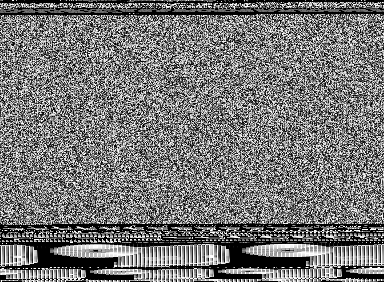



Imagen 2: Acierto - True Label: Fakerean, Predicted Label: Fakerean


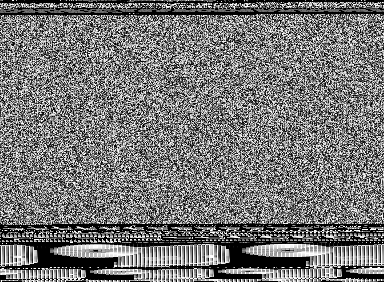



Imagen 3: Acierto - True Label: Yuner.A, Predicted Label: Yuner.A


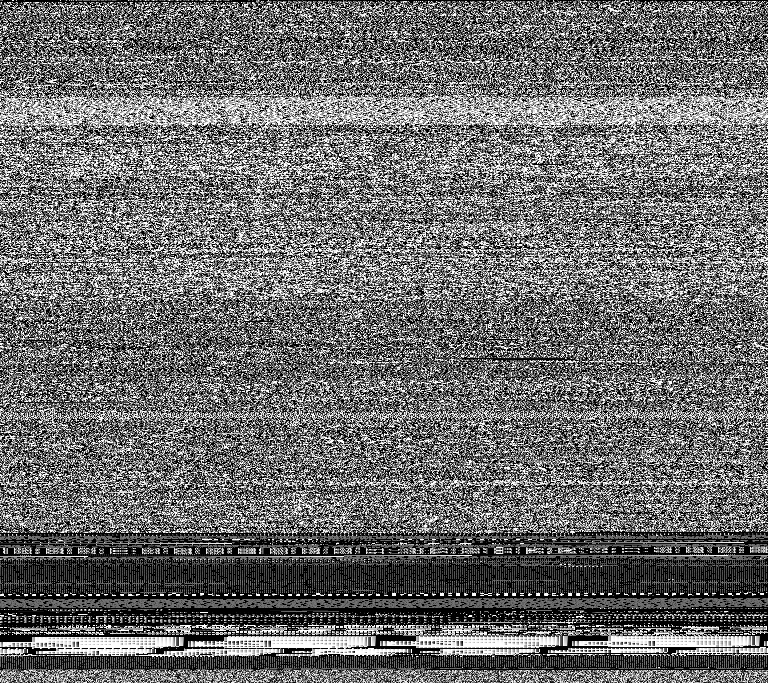



Imagen 4: Acierto - True Label: Agent.FYI, Predicted Label: Agent.FYI


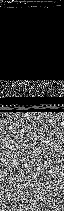



Imagen 5: Acierto - True Label: Agent.FYI, Predicted Label: Agent.FYI


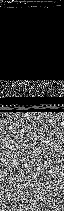



Imagen 6: Acierto - True Label: Agent.FYI, Predicted Label: Agent.FYI


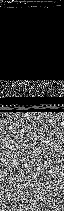



Imagen 7: Acierto - True Label: Agent.FYI, Predicted Label: Agent.FYI


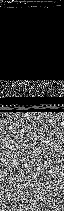



Imagen 8: Acierto - True Label: Fakerean, Predicted Label: Fakerean


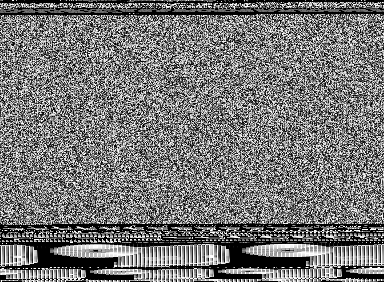



Imagen 9: Acierto - True Label: Agent.FYI, Predicted Label: Agent.FYI


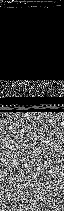



Imagen 10: Acierto - True Label: Fakerean, Predicted Label: Fakerean


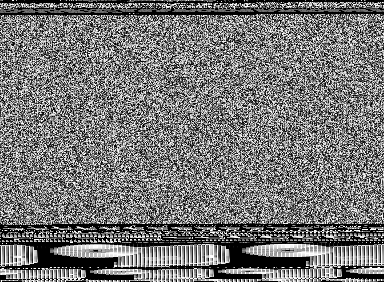

In [ ]:
# Clasificar 10 imágenes aleatorias del conjunto de prueba y mostrarlas con sus etiquetas verdaderas y predichas
random_indices = np.random.choice(X_test.shape[0], size=10, replace=False)
print("\nClasificación de 10 imágenes aleatorias del conjunto de prueba:")
for i, idx in enumerate(random_indices):
    true_label = class_names[y_test[idx]]
    predicted_label = class_names[y_pred[idx]]
    if true_label == predicted_label:
        print(f"\n\nImagen {i+1}: Acierto - True Label: {true_label}, Predicted Label: {predicted_label}")
    else:
        print(f"\n\nImagen {i+1}: Error - True Label: {true_label}, Predicted Label: {predicted_label}")


    # Cargar la imagen y mostrarla
    img_path = os.path.join(data_dir, true_label, os.listdir(os.path.join(data_dir, true_label))[0])
    img = cv2.imread(img_path)
    cv2_imshow(img)


Como podemos ver, todas las salidas del clasificador han sido aciertos. Por lo tanto, para esas 10 imágenes aleatorias que no ha visto nunca, el clasificador SVM ha tenido una tasa de acierto del 100%.

## EJERCICIO 4

El fichero “genes.csv” contiene información de dos genes y la posibilidad de tener cáncer o no. Con todo ello se quiere crear un modelo que permita hacer un diagnóstico para un nuevo paciente teniendo en cuenta su similitud en un campo de n-dimensiones.

Elige el clasificador que más se adapte de entre los vistos en clase y usa scikit-learn junto con las librerías que necesites para resolver las siguientes cuestiones.



Importamos la base de datos y los visualizamos para ver cómo están distribuidos.

In [ ]:
uploaded = files.upload()

data = pd.read_csv('genes.csv', header=None)

Saving genes.csv to genes.csv


In [ ]:
# Visualización inicial
data.head()

0      1              2
0  Gene1  Gene2  CancerPresent
1    4.3    3.9              1
2    2.5    6.3              0
3    5.7    3.9              1
4    6.1    6.2              0

**1) Haz todo el preprocesamiento para crear un set de entrenamiento, otro de validación y uno de test qué permita hacer un diagnóstico lo mas preciso posible aplicando las estrategias pertinentes.**

Veamos cuántas observaciones tenemos en nuestro conjunto de datos.

In [ ]:
# Obtener el número de filas en el DataFrame
num_filas_orig = len(data)

# Mostrar el resultado
print(f"Número de filas en el DataFrame: {num_filas_orig}")

Número de filas en el DataFrame: 3001


El dataset cuenta con 3001 filas, observando la representación de la base de datos, se puede observar que la primera fila son los nombres de las columnas.

Comprobamos si esto es cierto para arreglarlo y poder trabajr mejor con la base.

In [ ]:
print(data.iloc[0])

0            Gene1
1            Gene2
2    CancerPresent
Name: 0, dtype: object


Efectivamente, la primera fila del dataset es el nombre de las columnas, que se leen como 0, 1 y 2, y esta primera fila hace referencia a qué significan.

Para que esta fila no influya en el análisis, renombramos las columnas del dataset y la eliminamos.

In [ ]:
data.columns = ['Gene1', 'Gene2', 'CancerPresent']

data.head()

Gene1  Gene2  CancerPresent
0  Gene1  Gene2  CancerPresent
1    4.3    3.9              1
2    2.5    6.3              0
3    5.7    3.9              1
4    6.1    6.2              0

Ya hemos comprobado que se han cambiado bien los nombres de las columnas, y ahora podemos proceder a eliminar la primera fila.

In [ ]:
data_valido = data.iloc[1:]
data_valido.head()

Gene1 Gene2 CancerPresent
1   4.3   3.9             1
2   2.5   6.3             0
3   5.7   3.9             1
4   6.1   6.2             0
5   7.4   3.4             1

Para seguir con la limpieza de la base de datos comprobamos si hay algún nan.

In [ ]:
print(data_valido['Gene1'].isna().sum())

0


Vemos que no hay valores nulos en ninguna de las columnas, por lo que tenemos ya la base de datos lista para poder trabajar con ella.

Por último, veamos de qué tipo son las variables.

In [ ]:
data_valido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 1 to 3000
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Gene1          3000 non-null   object
 1   Gene2          3000 non-null   object
 2   CancerPresent  3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


Todas las variables son  categóricas, por lo que, para poder tratar las columnas 'Gene1' y 'Gene2' como coordenadas y poder clasificarlas en base a cercanía, las tendremos que pasar a tipo numérico.

In [ ]:
# Convertir las columnas 'Gene1' y 'Gene2' a tipo numérico
data_valido = data_valido.copy()  # Crear una copia del DataFrame
data_valido['Gene1'] = pd.to_numeric(data_valido['Gene1'])
data_valido['Gene2'] = pd.to_numeric(data_valido['Gene2'])

Veamos cómo están distribuidos ambos clases en base a los genes.

Denominaremos la clase 0 como no cancer y la representaremos con color verde, y a la clase 1 como sí presencia de cáncer y la representaremos con el color rojo.

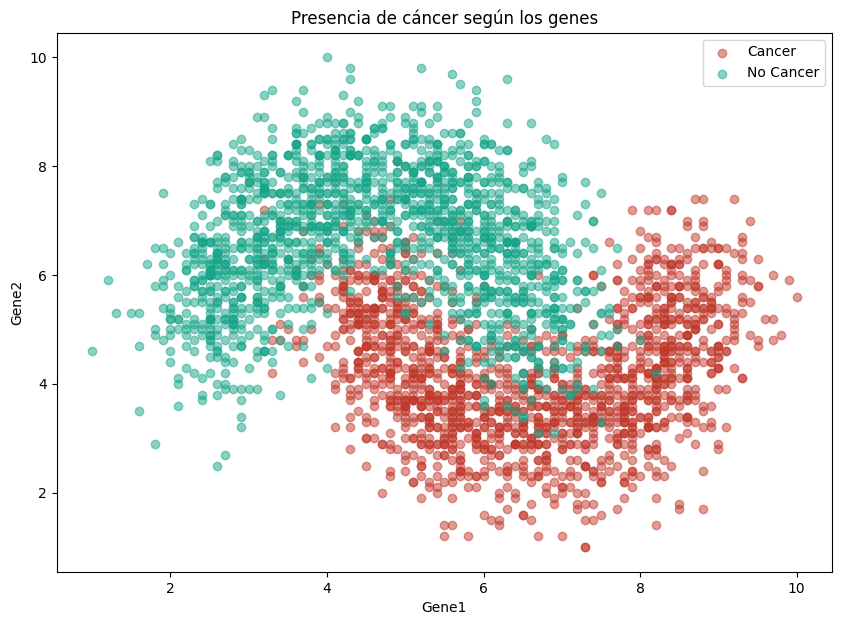

In [ ]:
# Crear el scatter plot
plt.figure(figsize=(10, 7))

# Filtrar por 'CancerPresent' == 'Yes'
plt.scatter(data_valido[data_valido['CancerPresent'] == '1']['Gene1'],
            data_valido[data_valido['CancerPresent'] == '1']['Gene2'],
            alpha=0.5, label='Cancer', color='#C0392B')

# Filtrar por 'CancerPresent' == 'No'
plt.scatter(data_valido[data_valido['CancerPresent'] == '0']['Gene1'],
            data_valido[data_valido['CancerPresent'] == '0']['Gene2'],
            alpha=0.5, label='No Cancer', color='#17A589')

plt.title('Presencia de cáncer según los genes')
plt.xlabel('Gene1')
plt.ylabel('Gene2')
plt.legend()
plt.show()

Para dividir el conjunto de datos en entrenamiento, validación y test, lo primero que haremos será dividir en conjunto X con todas las características (Gene1 y Gene2) y luego un conjunto Y (con la clase que se quiere predecir).

La estrategia que usaremos para la división será 70, 15, 15. 70% de los datos en el conjunto de entrenamiento, 15% para el conjunto de validación y el 15% restante como conjunto de test.

Une vez hecha la división, para combrobar que se haya hecho bien, mostramos la forma de cada conjunto.

In [ ]:
# División de los datos en características (X) y etiquetas (y)
X = data_valido[['Gene1', 'Gene2']]
y = data_valido['CancerPresent']

# Paso 1: División del conjunto de datos en entrenamiento y test (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 2: División del conjunto de test en entrenamiento y validación (50% - 50%)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Puedes imprimir las formas de tus conjuntos de datos para verificar
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

**2) Prueba con distintas configuraciones de las dos métricas principales. La primera métrica corresponde al número de individuos que usarás para clasificar una nueva instancia y la segunda cómo vas a medir la cercanía de esa nueva instancia con el resto. ¿Qué decisiones has tomado? ¿Por qué?**

**Número de K**

La estretegia que se ha usado para elegir los posibles valores de k es la siguiente:

Elegiremos un conjunto de números impares consecutivos. El motivo de que todos los K que vamos a probar sean impares es para evitar que a la hora de clasificar a un individuo se pueda generar un empate de clases, al coger un número impar de elementos es imposible que se genere un empate de clases.

Al ser un conjunto tan amplio, empezaremos cogiendo un K mínimo de 5, pues coger K muy bajos como 1 o 3 puede llegar a sesgar y no ser representativo del espacio. Cogeremos 5 valores para K (5, 7, 9, 11 y 13) y veremos cuál es el que mejor precisión aporta a la hora de clasificar.

**Tipos de distancias**

Usaremos 4 distancias diferentes para ver cuál es la que mejor se adapta a nuestro conjunto de datos. A la hora de elegir las distancias no contaremos con distancias que se usen cuando las variables son categóricas como puede ser la de hamming.

*Distancia Euclidea:*

La distancia euclidea es la longitud de la línea recta que conecta dos puntos en el espacio, se deduce a partir del teorema de Pitágoras. Se puede visualizar fácilmente en dos o tres dimensiones como la longitud de la línea más corta entre dos puntos.

$
d(P, Q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2}
$


*Distancia Manhattan:*


La distancia de Manhattan es una medida de distancia en la geometría que se calcula como la suma de las diferencias absolutas entre las coordenadas de los puntos. Su cálculo es a partir de los catetos opuesto y adyacente de un triángulo rectángulo, a diferencia de la euclidea en la que el cálculo esta dado por la hipotenusa.

$d(P, Q) = |p_1 - q_1| + |p_2 - q_2|
$

*Distancia Chebyshev:*

la distancia de Chebyshov es una métrica definida en un espacio vectorial donde la distancia entre dos puntos (representados por sus vectores) es la mayor de sus diferencias a lo largo de cualquiera de sus dimensiones coordenadas.

$d(P, Q) = \max\{|p_1 - q_1|, |p_2 - q_2|\}$


*Distancia Minkowski:*

Esta distancia puede considerarse una generalización de las distancias euclideas y Manhattan. Se utiliza comúnmente en aprendizaje automático como una métrica de distancia en algoritmos como los k-vecinos más cercanos (k-NN).

$d(P, Q) = \left( \sum_{i=1}^{n} |p_i - q_i|^p \right)^{\frac{1}{p}}
$

* Cuando $p=1$ obtenemos la distancia de Manhattan.
* Cuando $p=2$ obtenemos la distancia Euclidea.
* Cuando $p→∞$ obtenemos la distancia de Chebyshev.

Compararemos todas las distancias con todos los posibles K que estudiaremos con un búcle y mostraremos los resultados en una tabla en la que se pueda ver la precisión que se consigue entrenando el conjunto de datos en base a las distintas distancias y K correspondientes.

In [ ]:
# Definir una función para calcular la precisión basada en el número de vecinos y la distancia
def calculate_accuracy(X_train, y_train, X_val, y_val, k, metric):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn.fit(X_train, y_train)
    val_predictions = knn.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    return val_accuracy

# Crear una lista de listas para guardar los resultados
results = []

# Definir valores de k y métricas
k_values = [5, 7, 9, 11, 13]
metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev']

# Calcular la precisión para diferentes valores de k y métricas
for k in k_values:
    for metric in metrics:
        accuracy = calculate_accuracy(X_train, y_train, X_val, y_val, k, metric)
        results.append([k, metric, accuracy])

# Mostrar los resultados como una tabla
headers = ["k", "metric", "accuracy"]
print(tabulate(results, headers=headers, tablefmt="pretty"))

+----+-----------+--------------------+
| k  |  metric   |      accuracy      |
+----+-----------+--------------------+
| 5  | euclidean | 0.9222222222222223 |
| 5  | manhattan | 0.9266666666666666 |
| 5  | minkowski | 0.9222222222222223 |
| 5  | chebyshev | 0.9244444444444444 |
| 7  | euclidean | 0.9311111111111111 |
| 7  | manhattan | 0.9288888888888889 |
| 7  | minkowski | 0.9311111111111111 |
| 7  | chebyshev | 0.9288888888888889 |
| 9  | euclidean | 0.9444444444444444 |
| 9  | manhattan | 0.9355555555555556 |
| 9  | minkowski | 0.9444444444444444 |
| 9  | chebyshev |        0.94        |
| 11 | euclidean | 0.9333333333333333 |
| 11 | manhattan | 0.9333333333333333 |
| 11 | minkowski | 0.9333333333333333 |
| 11 | chebyshev | 0.9355555555555556 |
| 13 | euclidean | 0.9355555555555556 |
| 13 | manhattan | 0.9355555555555556 |
| 13 | minkowski | 0.9355555555555556 |
| 13 | chebyshev | 0.9377777777777778 |
+----+-----------+--------------------+


**3) Elige la mejor configuración entre las anteriores. Para ello dibuja una tabla para ver cómo evoluciona la clasificación. Dibuja los resultados que se obtienen con la mejor configuración y los distintos hiperparametros del punto anterior para ver su evolución.**

Dibujamos una gráfica para ver visualmente la precisión de los conjuntos en base a las diferentes métricas. También elegiremos la mejor combinación.

Mejor configuración:
k                   9
metric      euclidean
accuracy     0.944444
Name: 8, dtype: object


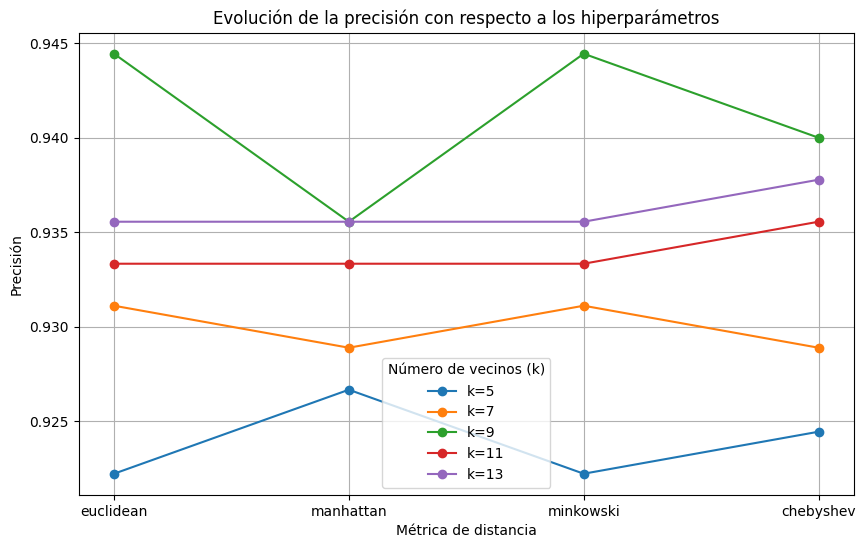

In [ ]:
# Convertir la lista de listas 'results' en un DataFrame de pandas
results_df = pd.DataFrame(results, columns=headers)

# Encontrar la mejor configuración
best_config = results_df.loc[results_df['accuracy'].idxmax()]

print("Mejor configuración:")
print(best_config)

# Gráfico de líneas para visualizar la evolución de la precisión
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for k in k_values:
    subset = results_df[results_df['k'] == k]
    plt.plot(subset['metric'], subset['accuracy'], marker='o', label=f'k={k}')

plt.title('Evolución de la precisión con respecto a los hiperparámetros')
plt.xlabel('Métrica de distancia')
plt.ylabel('Precisión')
plt.legend(title='Número de vecinos (k)')
plt.grid(True)
plt.show()

El mejor valor de K para clasificar nuestro conjunto de datos es 9. Los valores 5 y 7 dan las precisiones más bajas pues no son capaces de generalizar, y los valores 11 y 13, sobreajustan demasiado.

En cuanto a las distancias, dependiendo del K elegido varía algo más. En este caso, para k=9 las dos mejores distancias que aportan una precisión igual son la euclidea y la de minkowski. Elegimos la distancia euclidea al ser la más común para entrenar nuestro conjunto de test.

**4) Utiliza el clasificador para saber que ocurre con los datos de un del dataset de test “pacientes_test.csv” que obtendremos del dataset proporcionado.**

Entrenamos nuestro conjunto de test con un K=9 y la distancia Euclidea. Con el entrenamiento se conseguía una precisión de 94.44%

In [ ]:
# Obtener la mejor configuración
best_k = best_config['k']
best_metric = best_config['metric']

# Crear el clasificador con la mejor configuración
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)

# Entrenar el clasificador en el conjunto de entrenamiento
knn.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
test_predictions = knn.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
test_accuracy = accuracy_score(y_test, test_predictions)
print("Exactitud en el conjunto de prueba: {:.2%}".format(test_accuracy))

Exactitud en el conjunto de prueba: 93.78%


Se consigue un modelo con una precisión del 93.78%, que es muy pareciada a la obtenida con los datos de entrenamiento.